# Table of contents
Do subtraction ourselves to get the errorbar
1. [30mK data load, subtract, plot 2D, cut and fit](#30mk)
    * [define functions](#functions)
    * [Subtract and plot](#30mk_sub_plot2d)
    * [Plot different vertical layers](#30mk_layers)
    * [Cut along (HH0) and fit with PV](#30mk_fitPV)
    * [Cut along (HH0) and fit with Loritz](#30mk_fitLortz)
    * [Cut along (HH0) no zero layers](#30mk_cut_no0layers)
    * [Cut along (00L)](#30mk_cut00L)  
    * [Cut along vertical (H-H0)](#30mk_cutH-H0) 
    * [Cut and fit (002) peak](#30mk002)
    * [Cut 3D data: line and slice](#30mk_slice)
2. [450mK data load, subtract, plot 2D, cut and fit](#450mk)
3. [Orientation corrected data: subtraction and plot](#corrected)

# 30mK data load, subtract, plot 2D, cut and fit <a id='30mk'></a>

## Define functions <a id='functions'></a>

In [2]:
'''
If you want to use Matplotlib’s interactive plotting with Mayavi’s mlab in IPython you should:
%gui=qt
import matplotlib
matplotlib.use('Qt4Agg')
matplotlib.interactive(True)
'''
#######read hdf E2 File######
import h5py
import numpy as np
#from mayavi import mlab
import matplotlib.pyplot as plt
#from __future__ import print_function
import os.path

from scipy.optimize import curve_fit

#import scipy as sp
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d
#from smoothn import smoothn # use spline for smoothing: not good for Bragg peaks (minus values)

#import peakutils
import matplotlib as mpl
mpl.style.use('classic')
from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})  # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
% matplotlib notebook
#mlab.options.backend = 'envisage' # enable the full  UI of Mayavi

In [658]:
print(np.arctan(0.02/1.4)*180/3.1415)
print(np.arctan(0.03/1.68)*180/3.1415)
print(2*np.sin(3.3/180*3.1415))
print(0.0579/0.717)
Ns = np.array([1,2,3])
B = 0.5
print(0.1+Ns*B*5.3*0.05787*np.sin(0.83)/np.sqrt(3.))
print(2*np.pi/2.65)
print(26*0.25*10)
print(0.14*3/0.05787/1.8)
print(0.25**2*np.pi*4)
print(550*21./60.)

0.8184796007421274
1.0230603613304003
0.11512466225401964
0.0807531380753
[0.16534 0.23067 0.29601]
2.37101332346
65.0
4.03202580497
0.785398163397
192.5


In [3]:
class E2_data(object):
    x = 0; y = 0; z = 0
    I = 0; e = 0
    I2d = 0; e2d = 0
    # The class "constructor" - It's actually an initializer 
    def __init__(self, x,y,z,I,e,I2d,e2d):
        self.x = x
        self.y = y
        self.z = z
        self.I = I
        self.e = e
        self.I2d = I2d
        self.e2d = e2d
        
class E2_data_1d(object):
    x = 0; I = 0; e = 0
    def __init__(self, x,I,e):
        self.x = x
        self.I = I
        self.e = e
        
class E2_data_2d(object):
    x = 0; y = 0; I = 0; e = 0
    def __init__(self, x,y,I,e):
        self.x = x
        self.y = y
        self.I = I
        self.e = e
        
# loadE2_obj0 & cut2d0: for getting the error in the unsubtraced data
def loadE2_obj0(fpath, fname, info=0):# set empty pixels to nan and calcuations the error for 2D data
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    if info:
        for index,key in enumerate(ks[:5]):  
            print(index, key, np.shape(hf[key][0:]))       
    x, y, z, data, error = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Axes2'][0:], hf[u'Data'][0:], hf[u'Sigma'][0:]
    data[[0,9],:,:], error[[0,9],:,:] = np.nan, np.nan # the error of these layers is too large or value is nan !only for data with 10 layers)
    data = np.where(data==0,np.nan, data)
    error = np.where(error==1,np.nan, error)
    #return E2_data(x,y,z,data,error,
    #               np.nanmean(data,axis=0), np.nanmean(error**2,axis=0)**0.5)# not exact, it should be: sqrt[sum(a^2)/(n-1)]
    return E2_data(x,y,z,data,error,
                   np.nanmean(data,axis=0), np.nanmean(error,axis=0)/np.sum(~np.isnan(error),axis=0))# underestimate the error

def cut2d0(e2_obj, ool, hho, intax):# ool is row (ax=0), hho is col(ax=1)
    mask0 = (e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])
    mask1 = (e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])

    cut = np.ix_(mask1, mask0)# ool is row, hho is col
    I2d, e2d = e2_obj.I2d[cut], e2_obj.e2d[cut]
    I2d, e2d = np.nanmean(I2d, axis=intax), np.nanmean(e2d,axis=intax)/np.sum(~np.isnan(e2d),axis=intax) #(np.nanmean(e2d**2,axis=intax))**0.5
       
    if intax==1: # integrate the (hho) axis
        ax = e2_obj.y[(e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])]
    elif intax==0: # integrate the (ool) axis
        ax = e2_obj.x[(e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])]
    return E2_data_1d(ax, I2d, e2d)

def cut3d(e2_obj, h_ho, ool, hho, intaxs):# h_ho is page(ax=0), ool is row (ax=1), hho is col(ax=2), intaxs (list) is axes to integrate over
    mask2 = (e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])
    mask1 = (e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])
    mask0 = (e2_obj.z>=h_ho[0])&(e2_obj.z<=h_ho[1])
    
    cut = np.ix_(mask0, mask1, mask2)
    I3d, e3d = e2_obj.I[cut], e2_obj.e[cut] 
    Icut, ecut = np.nanmean(I3d, axis=tuple(intaxs)), np.nanmean(e3d, axis=tuple(intaxs)) 
    # nanmean only take tuple to indecate multiple axes!!! (Tuple: (1,) is a tuple; (1) is a int)
    if len(intaxs)==2:# 1D cut
        ax = list(set([0,1,2])-set(intaxs))[0]
        if ax==0:
            axs = e2_obj.z[mask0]
        elif ax==1: 
            axs = e2_obj.y[mask1]
        elif ax==2:
            axs = e2_obj.x[mask2]
        return E2_data_1d(axs, Icut, ecut)
    elif len(intaxs)==1:# 2D slice
        if intaxs[0]==0:
            axs_x = e2_obj.y[mask1]
            axs_y = e2_obj.x[mask2]
        elif intaxs[0]==1: 
            axs_x = e2_obj.z[mask0]
            axs_y = e2_obj.x[mask2]
        elif intaxs[0]==2:
            axs_x = e2_obj.z[mask0]
            axs_y = e2_obj.y[mask1]
        return E2_data_2d(axs_x, axs_y, Icut, ecut)

def subE2_obj0(data,bkg):
    #if (data.x == bkg.x) & (data.y == bkg.y)& (data.z == bkg.z):
    if np.array_equal(data.x, bkg.x) & np.array_equal(data.y, bkg.y) & np.allclose(data.z, bkg.z,rtol=0.01):# use 'allclose' for z due to small difference in the velues
        x = data.x
        y = data.y
        z = data.z
        I = data.I - bkg.I
        e = np.abs(data.e) + np.abs(bkg.e)
        I2d = data.I2d - bkg.I2d
        e2d = np.abs(data.e2d) + np.abs(bkg.e2d)
        return E2_data(x,y,z,I,e,I2d,e2d) # a object
    else:
        print('sizes do not match')    
        print(np.array_equal(data.x, bkg.x),np.array_equal(data.y, bkg.y),np.array_equal(data.z, bkg.z))
        print(data.z, bkg.z)

def subE2_obj1(data,bkg): # only subtract the common region
    #if (data.x == bkg.x) & (data.y == bkg.y)& (data.z == bkg.z):
    if np.array_equal(data.x, bkg.x) & np.array_equal(data.y, bkg.y) & np.allclose(data.z, bkg.z,rtol=0.01):# use 'allclose' for z due to small difference in the velues
        x = data.x
        y = data.y
        z = data.z
        I = data.I - bkg.I
        e = np.abs(data.e) + np.abs(bkg.e)
        mask = (data.I!=0) & (bkg.I!=0) # only subtract the common region
        I = np.where(mask, I, np.nan)
        e = np.where(mask, e, np.nan)       
        I2d, e2d = np.nanmean(I,axis=0), np.nanmean(e,axis=0)/np.sum(~np.isnan(e),axis=0)
        return E2_data(x,y,z,I,e,I2d,e2d) # a object
    else:
        print('sizes do not match')    
        print(np.array_equal(data.x, bkg.x),np.array_equal(data.y, bkg.y),np.array_equal(data.z, bkg.z))
        print(data.z, bkg.z)
        
def loadE2_2D(fpath, fname):
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    for index,key in enumerate(ks[:5]):  
        print(index, key, np.shape(hf[key][0:]))
    x, y, data = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Data'][0:]
    return x, y, data

from scipy import ndimage
def myGfilter(U, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0,nanout=1): 
    #Gaussian filter with igonoring 'nan'
    #https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    
    nans = U!=U # positions of nan: nan is not equal to nan
    V=U.copy()
    V[nans]=0 # replace 'nan' by 'zero'
    VV=ndimage.gaussian_filter(V, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

    W=0*U.copy()+1 
    W[nans]=0 # label 'nan' and values with '0' and '1' respectively
    WW=ndimage.gaussian_filter(W, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    
    output = VV/WW
    if nanout:
        output[nans] = np.nan
    return output

def plot2D(x, y, data, vmin, vmax, xlim, ylim, ax='None'):  
    if ax=='None':
        fig = plt.figure(figsize=(5,4)); #plt.gca().set_aspect(aspect)
        ax = plt.gca()
    pcol = ax.pcolormesh(x, y, data, cmap='jet',linewidth=0,rasterized=True,vmin=vmin, vmax=vmax)
    pcol.set_edgecolor('face') # remove the white lines in the plot
    ax.grid()
    
    #plt.axis(axlim)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('(HH0)',size=14)
    ax.set_ylabel('(00L)',size=14)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10)

    #cb = plt.colorbar(pcol, ax=ax)
    #cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    #cb.ax.tick_params(labelsize=12)
    #plt.show()
    return plt.gcf(), plt.gca()#, cb

from lmfit.lineshapes import pvoigt # pvoigt(x, amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5)
def wrapper_fit_func_PV(x,N,*args):# multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    return y

def wrapper_fit_func_PV_const(x,N,const,*args): # multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    return y + np.full_like(y,const)

def wrapper_fit_func_PV_const_k(x,N,const,k,*args): # multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    return y + np.full_like(y,const)+ k*x


## 30mK data load, subtract and plot 2D <a id='30mk_sub_plot2d'></a>

In [5]:
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix300_300_10_rot0p22_abc7p51_10p61_7p51/'
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix750_750_10_rot0p2_abc7p51_10p61_7p51/'
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # 10 points vertical
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110' # 10 points vertical
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51' # 50 points vertical
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51'

''' Data with pixel 750_750_10: the zeroth and nineth are small layers
    for 500 and 300 data:       only the zeroth are small layers with large error but the nineth layer is empty
'''
fname = [r'30mK_0p25T_one30-e210913.hdf',
         r'30mk_0p5T_one90-e210909.hdf',
         r'30mk_0p75T_one30-e210914.hdf',
         r'30mK_1T_two180-e210910-911-915.hdf',
         r'30mk_1p25T_one30-e210916.hdf',
         r'30mk_1p5T_one30-e210917.hdf',
         r'30mk_1p75T_e210918.hdf', 
         r'30mk_2T_one90-e210912.hdf']

fname_all = [
         r'20k_0T_two180 -e210922_23_24.hdf',
         r'30mK_0T_1and_half180-e210896_98_919.hdf',
         r'30mK_0p25T_one30-e210913.hdf',
         r'30mk_0p5T_one90-e210909.hdf',
         r'30mk_0p75T_one30-e210914.hdf',
         r'30mK_1T_two180-e210910-911-915.hdf',
         r'30mk_1p25T_one30-e210916.hdf',
         r'30mk_1p5T_one30-e210917.hdf',
         r'30mk_1p75T_e210918.hdf', 
         r'30mk_2T_one90-e210912.hdf']

fname_90deg = [
         r'20k_0T_two180 -e210922_23_24.hdf',
         r'30mK_0T_1and_half180-e210896_98_919.hdf',
         r'30mk_0p5T_one90-e210909.hdf',
         r'30mK_1T_two180-e210910-911-915.hdf',
         r'30mk_2T_one90-e210912.hdf']

fnameBkg_20k  = '20k_0T_two180 -e210922_23_24.hdf'
fnameBkg_30mk = '30mK_0T_1and_half180-e210896_98_919.hdf'
bkg_20k  = loadE2_obj0(fpath,fnameBkg_20k)
bkg_30mk = loadE2_obj0(fpath,fnameBkg_30mk)

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
0.0023525146562956016 0.21932995017420548


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


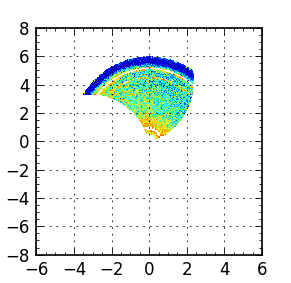

In [4]:
# Check the magnitude of error at different z values
data = loadE2_obj0(fpath,fname[1])

print np.nanmin(data.e), np.nanmax(data.e)
#Z = data.e/data.I
Z = data.I
Z[Z>0.04]=np.nan
Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color

plot2D(data.x, data.y, Zm[6,:,:], vmin=0, vmax= 0.05, xlim =None, ylim=None);

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


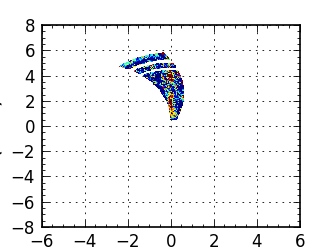

In [5]:
# Plot data
data = loadE2_obj0(fpath,fname[0])
sub = subE2_obj1(data,bkg_20k)
#sub = subE2_obj1(data,bkg_30mk)

sigma = [1,1]
#Z = myGfilter(data.e2d/data.I2d, sigma, mode='constant')
#Z = myGfilter(bkg.e2d/bkg.I2d, sigma, mode='constant')
#Z = myGfilter(sub.e2d/data.I2d/2, sigma, mode='constant')
#Z = myGfilter(sub.e2d/sub.I2d, sigma, mode='constant')
Z = myGfilter(sub.I2d, sigma, mode='constant')

## Mask the data of powder ring
x1, y1= np.meshgrid(sub.x,sub.y, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 )
Z[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.8)] = np.nan # for 30mK
Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color
plot2D(sub.x, sub.y, Zm, vmin=0,vmax=0.002, xlim =None, ylim=None);

# plt.figure(figsize=(5,4))
# mycut0 = cut2d0(sub,[0.6,0.65],[-0.5,1.3],0)
# x = mycut0.x
# y = mycut0.I
# e = mycut0.e
# mask = np.where(~np.isnan(y))
# x, y, e = x[mask],y[mask],e[mask]
# line,caps,bars = plt.errorbar(x, y, e, fmt='o',mec='none', capsize=0)

# mycut0 = cut2d0(sub,[0.6,1.5],[-0.5,1.3],0)
# x = mycut0.x
# y = mycut0.I
# e = mycut0.e
# mask = np.where(~np.isnan(y))
# x, y, e = x[mask],y[mask],e[mask]
# line,caps,bars = plt.errorbar(x, y, e, fmt='o',mec='none', capsize=0)
# plt.show()

# Plot different vertical layer <a id='30mk_layers'></a>

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_1p5T_one30-e210917.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


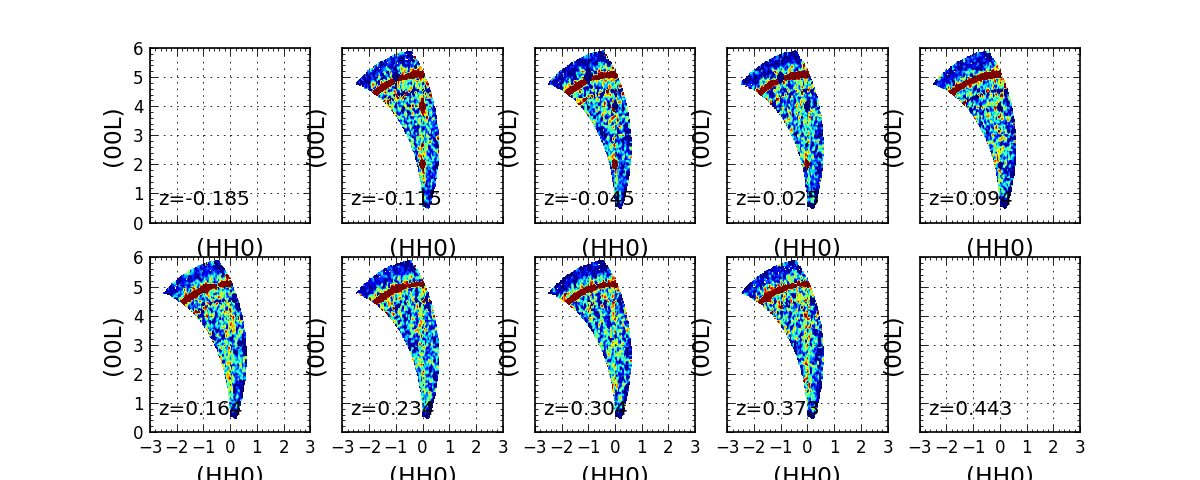

<IPython.core.display.Javascript object>


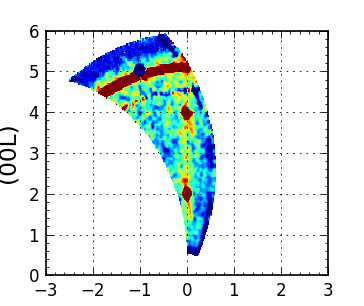

In [6]:
# Plot different vertical layers
bkg_20k = loadE2_obj0(fpath,fnameBkg_20k)
bkg_30mk = loadE2_obj0(fpath,fnameBkg_30mk)

data = loadE2_obj0(fpath,fname_all[7])
# smooth the backgroud: first remove the Bragg peaks
#bkg_20k.I[bkg_20k.I>0.04]=np.nan
#bkg_20k.I = myGfilter(bkg_20k.I, [0,3,3], mode='constant')# smooth with excluding nan
data = subE2_obj1(data, bkg_20k)

Z = data.I
sigma = [0,1.2,1.2]; Z = myGfilter(data.I, sigma, mode='constant')

Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color
fig, axs = plt.subplots(2,5,figsize=(10,4),sharex=True,sharey=True)
for idx, ax in enumerate(axs.reshape(-1)):
    plot2D(data.x, data.y, Zm[idx,:,:], vmin=0,vmax=0.01, xlim =[-3,3],ylim=[0,6],ax=ax);
    ax.text(0.05,0.1, 'z='+str(np.round(data.z[idx],3)),transform=ax.transAxes)
    
plot2D(data.x, data.y, np.nanmean(Zm[0:10,:,:],axis=0), vmin=0, vmax=0.008, xlim =[-3,3],ylim=[0,6]);

<IPython.core.display.Javascript object>


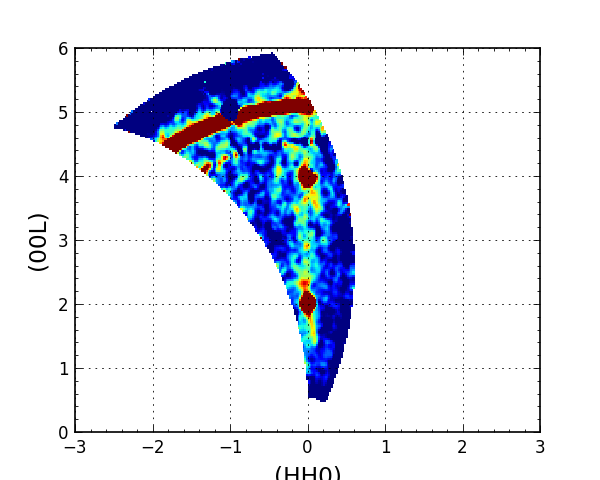

In [66]:
plot2D(data.x, data.y, np.nanmean(Zm[0:9,:,:],axis=0), vmin=0.002, vmax=0.008, xlim =[-3,3],ylim=[0,6]);

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


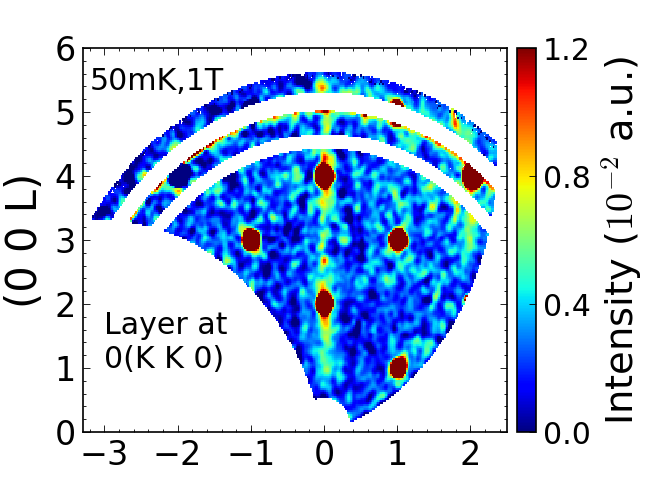

In [16]:
# Export figures: two layer for 0.5T and 1T

# Laod background data
bkg_20k = loadE2_obj0(fpath,fnameBkg_20k);
bkg_30mk = loadE2_obj0(fpath,fnameBkg_30mk);

# Mask based on the  90deg data and mask powder rings
data = loadE2_obj0(fpath, fname_all[3]) # Do not change!!! (30mK 0.5T)
z1, y1, x1 = np.meshgrid(data.z, data.y, data.x, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 + 2*z1**2)
Z0 = data.I
Z0[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.6)] = np.nan

# Load, subtraction, mask, smooth
whichF = 5 ######'3' for 30mK 0.5T; '5' for 1T #####
data = loadE2_obj0(fpath,fname_all[whichF]) 
data = subE2_obj1(data, bkg_20k)

Z = data.I
sigma = [0,1.5,1.5]; 
Z = myGfilter(Z, sigma, mode='constant')
Zm = np.ma.masked_where(np.isnan(Z0),Z)

# Plot layers
which = 1 ######'0' layer at 0.4(HH0); '1' for layer at 0(HH0) #####
vmin = [-0.002,-0.002,-0.01]
vmax = [0.012, 0.012, 0.03]
texts1 = ['20K,0T','50 mK,0T', '50 mK,0.25T','50mK,0.5T','50mK,0.75T','50mK,1T',
          '50mK,1.25T','50mK,1.5T','50mK,1.75T','50mK, 2.0T']
texts2 = ['Layer at\n0.4(K K 0)','Layer at\n0(K K 0)']
#texts2 = ['Layer at\n0.4[H H 0]','Layer at\n0(H H 0)']
figname = ['0p4layer','0layer']
matId = [8,2] # which layer
cbticks = [4,4]

fig = plt.figure(figsize=(5.5,4)); #plt.gca().set_aspect(aspect)
pcol = plt.pcolormesh(data.x, data.y, (Zm[matId[which],:,:]-vmin[which])*100, cmap='jet',vmin=0,vmax=vmax[which]*100, 
                      linewidth=0,rasterized=True)
pcol.set_edgecolor('face') # remove the white lines in the plot
plt.text(-3.2,5.35,texts1[whichF], fontsize=18)
plt.text(-3.,1.,texts2[which], fontsize=18)
plt.grid('off')

plt.axis([-3.3,2.5,0,6])
#plt.axes().set_aspect(0.717)
plt.xlabel('(H -H 0)',size=25)
plt.ylabel('(0 0 L)',size=25)
plt.minorticks_on()
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(which='both', direction='in')

cb = plt.colorbar(ticks=np.linspace(0,vmax[which]*100,num=cbticks[which],endpoint=True),pad=0.02)  # plt.colorbar(format='%.0e')
cb.ax.set_ylabel('Intensity ($10^{-2}$ a.u.)',fontsize=23)
cb.ax.tick_params(labelsize=18)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-3, 0))#cb.formatter.set_useOffset(0.001)
cb.draw_all()
plt.tick_params(which='both', direction='in')
cb.ax.tick_params(which='both', direction='in')
fig.savefig(os.path.join(fpath,fname_all[whichF].replace('.hdf', '_'+figname[which]+'.pdf')), bbox_inches="tight",verbose=True)
plt.show()

## Fit with PV funct <a id='30mk_fitPV'></a>

<IPython.core.display.Javascript object>


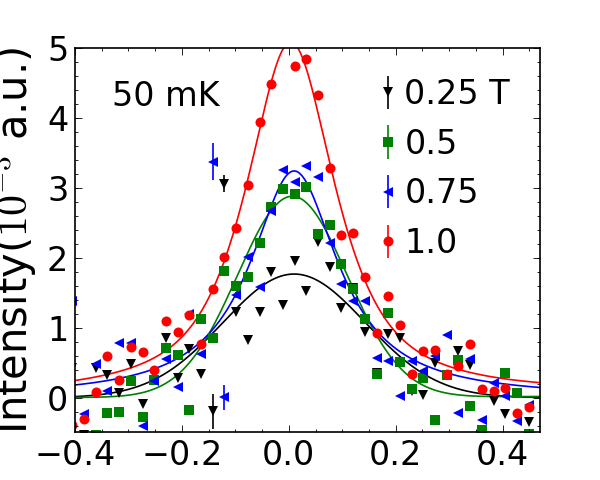

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: Mean of empty slice


[5.92039e-01 1.00000e-02 1.57248e-01 1.09847e-16]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
[7.40623e-01 6.50471e-03 1.20981e-01 1.84556e-26 2.04258e+00 1.00882e+00 1.73536e-02 4.60375e-01]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
[1.01853 0.01    0.1     1.     ]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
[1.50328 0.0036  0.1     0.87295 3.16233 1.00672 0.00913 0.99361]


In [670]:
# Cut the data and fit the streak and (110) peaks with PV peaks 
# with shift data for bkg corr.
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51'
xlabel = ['(H-H0)','(00L)']
legs = ['0.25 T','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['black','green','b','r','y','purple','grey','b']
markers = ['v', 's', '<', 'o', '8', 's', 'p']
xshift = np.array([0,0.,0.0,0.00,0,0,0,0,0])*0
yshift = np.array([0,0.0003,0, 0.0002,0,0.0005,0,0,0]) + 0.00012
intAx = 0 # 0: integrate ool, 1: integrate hho

xplot0 = np.linspace(-0.5,0.5,1000,endpoint=True)# plot the fit
xplot1 = np.linspace(-0.5,1.3,2000,endpoint=True)
pknb = [1,2,1,2,1,1,1,1]

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname):
    if idx==4:
        break
    data  = loadE2_obj0(fpath,fn,info=0)
    sub = subE2_obj1(data,bkg_20k)
    
    # Integrate 0-4(ool) excluding Bragg peaks
    mycut0 = cut2d0(sub,[1.2,1.8],[-0.5,1.3],0)
    #mycut1 = cut2d0(sub,[0.5,1.5],[-0.5,1.3],0)
    mycut1 = cut2d0(sub,[2.2,3.8],[-0.5,1.3],0)

      # method0: sum with nan; which lose data points
#     mask = np.where(np.isnan((mycut0.I+mycut1.I)/2.))
#     x = np.delete(mycut0.x, mask) + xshift[idx]
#     y = 1e3 * (np.delete((mycut0.I+mycut1.I)/2., mask) + yshift[idx])
#     e = 1e3 * 0.01 * np.delete(((mycut0.e**2+mycut1.e**2)/2)**0.5, mask)

      # method1: set nan to zero
#     x = mycut0.x + xshift[idx]
#     y = 1e3 * ( (np.nan_to_num(mycut0.I)+np.nan_to_num(mycut1.I))/2.+yshift[idx] )
#     e = 1e3 * 0.01 * ( (np.nan_to_num(mycut0.e)**2+np.nan_to_num(mycut1.e)**2) /2 )**0.5

    # method2: take care of nan in mean
    x = mycut0.x + xshift[idx]
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx] )
    #e = 1e3 * 1.01* np.nanmean(np.vstack([mycut0.e**2,mycut1.e**2]), axis=0)**0.5
    e = 1e3 * np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]

    line,caps,bars = plt.errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
    #plt.scatter(x,y,label=legs[idx], marker=markers[idx],c=colors[idx],edgecolors='none',s=35)    
    # Peak fit
    params_0 = [0.8, 0., 0.2, 0.5]
    bounds = [[0,    -0.00, 0.1, 0],
              [np.inf,0.01, 0.5, 1]] # amplitude, pos, withd, frac

    if pknb[idx]==2:            
        params_0 = [0.8,     0., 0.2, 0.5,  50,  1.0, 0.1, 0.5]
        bounds = [ [0,    -0.05, 0.1, 0,      0, 0.9, 0.0, 0],
                   [np.inf,0.05, 0.2, 1, np.inf, 1.2, 0.4, 1]] # amplitude, pos, withd, frac
        
    popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, pknb[idx], params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=e, absolute_sigma=False)# if initio value is outside bounds, error
    print popt
    
    if pknb[idx]==1: 
        plt.plot(xplot0,wrapper_fit_func_PV(xplot0,pknb[idx],popt),c=colors[idx])
    else:
        plt.plot(xplot1,wrapper_fit_func_PV(xplot1,pknb[idx],popt),c=colors[idx])

# #plt.axis([-0.5,1.3,-1,4])
#plt.axis([-0.5,0.55,-0.49,4])
plt.axis([-0.4,0.47,-0.49,5]); 
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))# plt.locator_params(axis='x', nticks=5)
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)

plt.minorticks_on()
plt.tick_params(labelsize=18)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

plt.text(0.08,0.85,'50 mK', fontsize=20, transform=plt.gca().transAxes)
plt.legend(loc='best',scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()
#plt.savefig(os.path.join(fpath,'30mk_cut_diffues1.pdf'), bbox_inches="tight",verbose=True)
plt.show()


## Fit along (HH0) with Loritz <a id='30mk_fitLortz'></a>

In [671]:
from lmfit import Model, CompositeModel
from lmfit.lineshapes import lorentzian, gaussian
def insRes(x,sigma_g):
    return gaussian(x, amplitude=1, center=0, sigma=sigma_g)
def myLorentz(x, amplitude, center, sigma, const):
    return lorentzian(x, amplitude, center,sigma) + np.full_like(x, const)
def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

### Fit single peak with lmfit

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


[[Model]]
    (Model(insRes) <function convolve at 0x000000038F1F5DD8> Model(myLorentz))
[[Fit Statistics]]
    # function evals   = 53
    # data points      = 46
    # variables        = 4
    chi-square         = 19.638
    reduced chi-square = 0.468
    Akaike info crit   = -31.154
    Bayesian info crit = -23.840
[[Variables]]
    sigma_g:     0.02 (fixed)
    amplitude:   0.04152697 +/- 0.007686 (18.51%) (init= 0.01)
    center:     -0.01192420 +/- 0.009479 (79.50%) (init= 0)
    sigma:       0.13292124 +/- 0.023234 (17.48%) (init= 0.1)
    const:      -0.01778160 +/- 0.005901 (33.19%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, const)          = -0.921 
    C(amplitude, sigma)          =  0.907 
    C(sigma, const)              = -0.800 



<IPython.core.display.Javascript object>


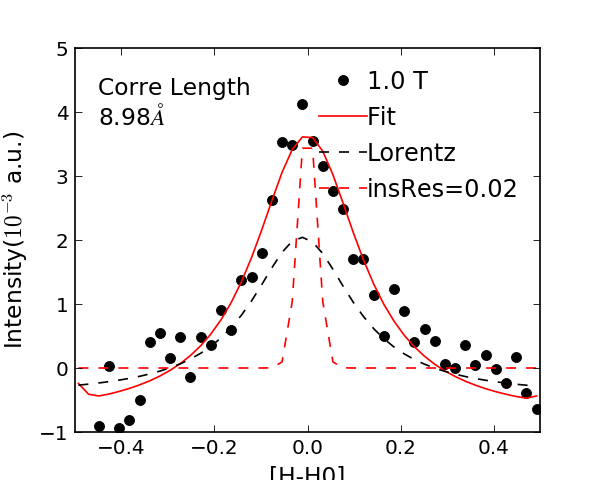

Correlation Length is 8.98310 in unit of $\AA$


In [672]:
# Fit data
# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0,sigma_g=0.02)
pars['sigma_g'].set(value=0.02,vary = False)

# fit this model to data array y

idx = 3 # which file
data  = loadE2_obj0(fpath,fname[idx],info=0)
sub = subE2_obj0(data,bkg_20k)
mycut0 = cut2d0(sub,[0.5,1.5],[-0.5,0.5],0)
mycut1 = cut2d0(sub,[2.2,3.8],[-0.5,0.5],0)
legs = ['0.25 T','0.5 T','0.75 T','1.0 T','1.25 T','1.50 T','1.75 T','2.0 T']
yshift = np.array([0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
x = mycut0.x + xshift[idx]
y = 1e3 * (np.nanmean(np.vstack([mycut0.I,mycut1.I]),axis=0) + yshift[idx] )
e = 1e3 * 0.01 * np.nanmean(np.vstack([mycut0.e**2,mycut1.e**2]), axis=0)**0.5
mask = np.where(~np.isnan(y))
x, y, e = x[mask],y[mask],e[mask]

result =  mod.fit(y, params=pars, x=x)
print(result.fit_report())

# plot results
plt.figure(figsize=(5,4))
plt.plot(x, y, 'ko',label=legs[idx])

plt.plot(x, result.best_fit, 'r-',label='Fit')
comps = result.eval_components(x=x)
plt.plot(x, 25*comps['myLorentz'], 'k--',label='Lorentz')
plt.plot(x, 0.2*comps['insRes'], 'r--',label='insRes='+'%1.2f'%pars['sigma_g'].value)

sigma = result.best_values['sigma']
unit110 = 2*np.pi/(10.61/np.sqrt(2.))
correL = 1/(unit110*sigma)

plt.text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=14, transform=plt.gca().transAxes)

plt.axis([-0.5,0.5,-1,5])
plt.xlabel('[H-H0]',size=14)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=14)
plt.legend(numpoints=1,frameon=False,handletextpad=0)
plt.show()

print(r'Correlation Length is {:1.5f} in unit of $\AA$'.format(1/(unit110*sigma)))

In [18]:
unit110 = 2*np.pi/(10.61/np.sqrt(2.))
sigma = 0.4
correL = 1/(unit110*sigma)
print correL

2.985111285758405


### Fit all the data together

<IPython.core.display.Javascript object>


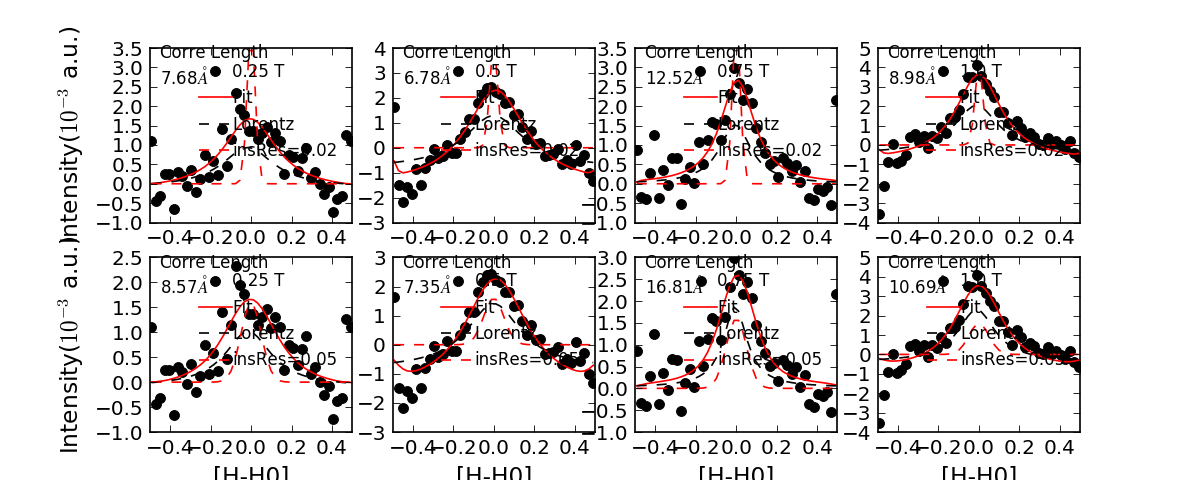

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


In [673]:
# Fit all the data together
legs = ['0.25 T','0.5 T','0.75 T','1.0 T','1.25 T','1.50 T','1.75 T','2.0 T']
xshift = np.array([0,0.0000,0, 0.0000,0,0.0000,0,0,0])
yshift = np.array([0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0

# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0, sigma_g=0.02)
pars['center'].set(min=-0.1, max=0.1)
sigma_gs = [0.02, 0.05]

# fit this model to data array y
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(10,4))
for idx, fn in enumerate(fname):
    if idx==4:
        break
    data  = loadE2_obj0(fpath,fn,info=0)
    sub = subE2_obj0(data,bkg_20k)
    
    mycut0 = cut2d0(sub,[0.5,1.5],[-0.5,0.5],0)
    mycut1 = cut2d0(sub,[2.2,3.8],[-0.5,0.5],0)
    
    x = mycut0.x + xshift[idx]
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I,mycut1.I]),axis=0) + yshift[idx] )
    e = 1e3 * 0.01 * np.nanmean(np.vstack([mycut0.e**2,mycut1.e**2]), axis=0)**0.5
    
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]
    
    for ii in [0,1]:
        pars['sigma_g'].set(value=sigma_gs[ii],vary = False)
        result =  mod.fit(y, params=pars, x=x)
        #print(result.fit_report())

        # plot results
        axs[ii,idx].plot(x, y, 'ko',label=legs[idx])

        axs[ii,idx].plot(x, result.best_fit, 'r-',label='Fit')
        comps = result.eval_components(x=x)
        axs[ii,idx].plot(x, 25*comps['myLorentz'], 'k--',label='Lorentz')
        axs[ii,idx].plot(x, 0.2*comps['insRes'], 'r--',label='insRes='+'%1.2f'%pars['sigma_g'].value)

        sigma = result.best_values['sigma']
        unit110 = 2*np.pi/(10.61/np.sqrt(2.))
        correL = 1/(unit110*sigma)

        axs[ii,idx].text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=10, transform=axs[ii,idx].transAxes)

        axs[ii,idx].set_xlim([-0.5,0.5])
        if idx ==0:
            axs[ii,idx].set_ylabel('Intensity($10^{-3}$ a.u.)',size=14)
        if ii==1:
            axs[ii,idx].set_xlabel('[H-H0]',size=14)
        axs[ii,idx].legend(numpoints=1,frameon=False,handletextpad=0,fontsize=10)
plt.show()

### Fit with two sigma_gs=[0.02, 0.05]

<IPython.core.display.Javascript object>


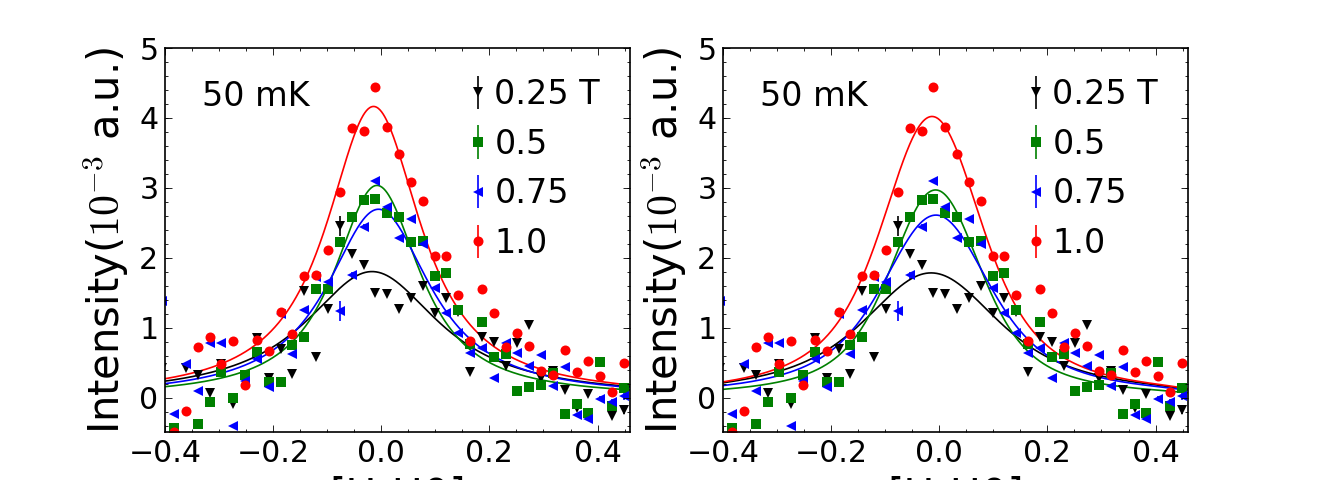

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


In [84]:
# Cut the data and fit the streak and (110) peaks with PV peaks 
# with shift data for bkg corr.
# Fit with lmfit for two sigma_gs=[0.02, 0.05]
          
xlabel = ['(H-H0)','(00L)']
legs = ['0.25 T','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['black','green','b','r','y','purple','grey','b']
markers = ['v', 's', '<', 'o', '8', 's', 'p']
xshift = np.array([0,0.,0.0,0.00,0,0,0,0,0])*0
yshift = np.array([0,0.0003,0.000, 0.0002,0,0.0005,0,0,0]) + 0.00012
intAx = 0 # 0: integrate ool, 1: integrate hho

# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0, sigma_g=0.02)
pars['const'].set(value=0,vary = False)
pars['center'].set(min=-0.1, max=0.1)
sigma_gs = [0.02, 0.05]

xplot0 = np.linspace(-0.5,0.5,1000,endpoint=True)# plot the fit

# fit this model to data array y
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
for idx, fn in enumerate(fname):
    if idx==4:
        break
    data  = loadE2_obj0(fpath,fn,info=0)
    sub = subE2_obj1(data,bkg_20k)
    
    mycut0 = cut2d0(sub,[0.5,1.5],[-0.5,0.5],0)
    mycut1 = cut2d0(sub,[2.2,3.8],[-0.5,0.5],0)
    
    x = mycut0.x + xshift[idx]
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx] )
    e = 1e3 * np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]    

    for ii in [0,1]:
        pars['sigma_g'].set(value=sigma_gs[ii],vary = False)
        result =  mod.fit(y, params=pars, x=x)
        #print(result.fit_report())
        
        sigma = result.best_values['sigma']
        unit110 = 2*np.pi/(10.61/np.sqrt(2.))
        correL = 1/(unit110*sigma)
        #axs[ii].text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=10, transform=axs[ii,idx].transAxes)

        # plot results +'%1.2f'%correL
        axs[ii].errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
        #pars.loads(result.params.dumps())
        axs[ii].plot(xplot0, result.eval(x=xplot0)/22, c=colors[idx]) # '/22': more X points larger Y due to Conv method!!!
        #axs[ii].plot(x, result.best_fit, c=colors[idx])
        #comps = result.eval_components(x=x)
        #axs[ii].plot(x, 25*comps['myLorentz'], 'k--',label='Lorentz')
        #axs[ii].plot(x, 0.2*comps['insRes'], 'r--',label='insRes='+'%1.2f'%pars['sigma_g'].value)

for ii in [0,1]:
    axs[ii].set_xlim([-0.4,0.46]); 
    axs[ii].set_ylim([-0.49,5]); 
    axs[ii].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[ii].minorticks_on()
    
    axs[ii].tick_params(labelsize=18)
    #axs[ii].Tick(axes='both',size=20)
    
    axs[ii].set_xlabel('[H-H0]',size=25)
    axs[ii].set_ylabel('Intensity($10^{-3}$ a.u.)',size=25)
    
    #axs[ii].text(0.08,0.8,'50 mK\n$\sigma_G=$'+str(sigma_gs[ii]), fontsize=20, transform=axs[ii].transAxes)
    axs[ii].text(0.08,0.85,'50 mK', fontsize=20, transform=axs[ii].transAxes)
    axs[ii].legend(loc='best',scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()

#plt.savefig(os.path.join(fpath,'30mk_cut_diffues.pdf'), bbox_inches="tight",verbose=True)
plt.show()

### Fit with lmfit for one sigma_gs=[0.02]

<IPython.core.display.Javascript object>


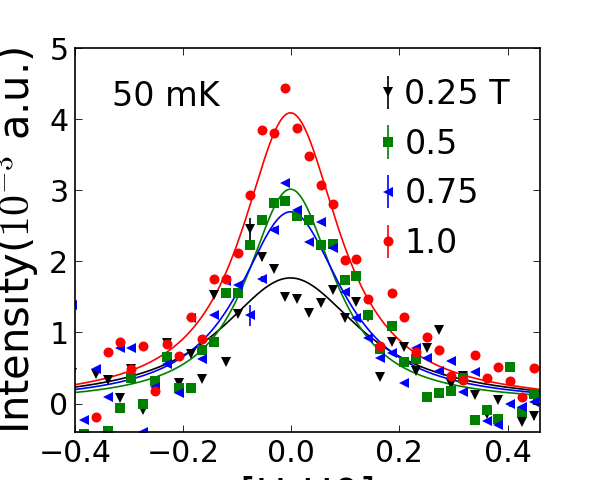

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: Mean of empty slice


7.809676437747859
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
13.19247467722024
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
10.875661034922985
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
11.604555245087603


In [85]:
# Fit with lmfit for one sigma_gs=[0.02]
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(5,4))
pars['const'].set(value=0,vary = False)
pars['center'].set(min=-0.002, max=0.002)
sigma_gs=0.02
pars['sigma_g'].set(value=sigma_gs,vary = False)

for idx, fn in enumerate(fname):
    if idx==4:
        break
    data  = loadE2_obj0(fpath,fn,info=0)
    sub = subE2_obj1(data,bkg_20k)
    
    mycut0 = cut2d0(sub,[0.5,1.5],[-0.5,0.5],0)
    mycut1 = cut2d0(sub,[2.2,3.8],[-0.5,0.5],0)
    
    x = mycut0.x + xshift[idx]
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx] )
    e = 1e3 * np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]    
 
    result =  mod.fit(y, params=pars, x=x)

    sigma = result.best_values['sigma']
    unit110 = 2*np.pi/(10.61/np.sqrt(2.))
    correL = 1/(unit110*sigma)
    print(correL)
    #axs.text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=10, transform=axs[ii,idx].transAxes)

    axs.errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
    axs.plot(xplot0, result.eval(x=xplot0)/22, c=colors[idx]) # '/22': more X points larger Y due to Conv method!!!
        
plt.axis([-0.4,0.46,-0.4,5.])
axs.xaxis.set_major_locator(plt.MaxNLocator(5))
#axs.minorticks_on()
axs.tick_params(labelsize=18)
axs.set_xlabel('[H-H0]',size=25)
axs.set_ylabel('Intensity($10^{-3}$ a.u.)',size=25)

#axs[ii].text(0.08,0.8,'50 mK\n$\sigma_G=$'+str(sigma_gs[ii]), fontsize=20, transform=axs[ii].transAxes)
axs.text(0.08,0.85,'50 mK', fontsize=20, transform=axs.transAxes)
axs.legend(loc=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()
#plt.savefig(os.path.join(fpath,'30mk_cut_diffues00.pdf'), bbox_inches="tight",verbose=True)
plt.show()

### Cut without the zero layers and polt with simulations <a id='30mk_cut_no0layers'></a>

In [674]:
# Calculated scattering of iD FM chain
simu = np.genfromtxt(r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\FM_chain.txt')

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


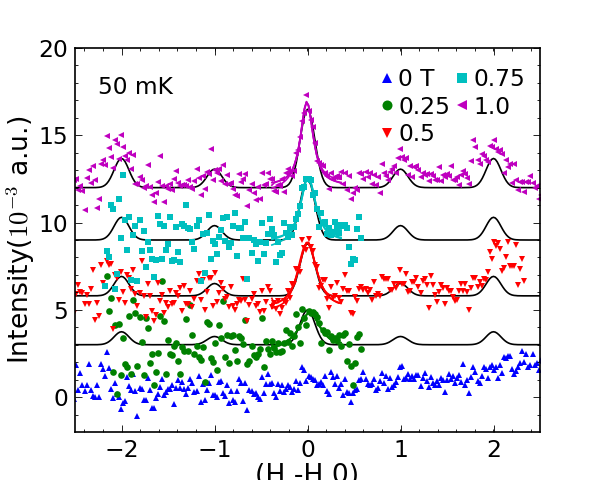

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf
({'sigma': 0.14162626983528778, 'const': -7.569663808189908e-06, 'center': 0.013723359532801984, 'amplitude': 2.153261987427981e-05, 'sigma_g': 0.02}, '\n', 8.430953633757657)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
({'sigma': 0.11259246779210644, 'const': -2.272211402000503e-05, 'center': -0.010106659800418858, 'amplitude': 3.1346238335031237e-05, 'sigma_g': 0.02}, '\n', 10.605012375322262)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
({'sigma': 0.09102097702542698, 'const': -3.4242704939782362e-06, 'center': -0.0025420519868800317, 'amplitude': 2.456887159368829e-05, 'sigma_g': 0.02}, '\n', 13.11834429078697)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\

In [677]:
# Cut the 30mK data and plot spline
xlabel  = ['(H -H 0)','(0 0 L)']
legs    = ['0 T','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
markers = ['^','o','v', 's', '<', 'o', '8', 's', 'p']
colors  = ['g','bk','green','y','b','r','y','g','r','b']
xshift  = [0,0,0.0002,0,-0.0002,0,0,0,0,0]
yshift  = 3
# amplitude and shfit of simulation for h_ho=[0.2,0.5]
yshift_simu = [0,0,-0.2,0,0,0,0,0,0]
simu_amp = [0,20,30,35,45,45,45,45,45,45]
intAx = 0 # 0: integrate ool, 1: integrate hho

# Mask for the powder rings
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # 10 points vertical
data = loadE2_obj0(fpath, fname_all[3]) # Do not change!!! (30mK 0.5T)
z1, y1, x1 = np.meshgrid(data.z, data.y, data.x, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 + 2*z1**2)
mask = (rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.6)

xfit = np.linspace(-0.8,0.8,100)
fitpars_pv_const = []
fitpars_pv_const_k = []

mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0,sigma_g=0.02)
pars['sigma_g'].set(value=0.02,vary = False)
fitpars_lm = []

dofit = [True,True,True]
#dofit = [False,False,False]

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname_all[1:6]):
#     if idx==11:
#         break
    # first plot simulation
    if idx!=0:
        simu_sm = np.vstack([simu[:,0],gaussian_filter1d(simu[:,1],sigma=4)/np.max(simu[:,1])]).T
        plt.plot(simu_sm[:,0], simu_amp[idx]*simu_sm[:,1]+yshift*idx+yshift_simu[idx], c='black')
        
    dat = loadE2_obj0(fpath, fn, info=0)
    dat = subE2_obj1(dat, bkg_20k)
    dat.I[mask] = np.nan
    
    # Cut along [hh0] integrating (ool) and all vertical (h-ho)
    #mycut0 = cut3d(dat, h_ho=[0.1,0.5], ool=[0,1.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut1 = cut3d(dat, h_ho=[0.1,0.5], ool=[2.2,3.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut  = cut3d(dat, h_ho=[0.1,0.5], ool=[4.2,4.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut.I = np.nanmean(np.vstack([mycut0.I, mycut1.I, mycut.I]), axis=0)
    
    mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[1.5,6], hho=[-5,5], intaxs=[0,1]) 
    #mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[0,3], hho=[-5,5], intaxs=[0,1]) # to show the streak at [110]
    #mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[3,5], hho=[-5,5], intaxs=[0,1]) # to show the streak at [224]
    
    
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift*idx, 1e3*0.00001*maskede, marker=markers[idx], 
                                  markersize=4,fmt='o',mec='none',
                                  label=legs[idx], lw=0.3, capsize=0)
    # Fit the peak
    x, y = maskedx[210:245], maskedy[210:245]
    
    if idx!=0 and dofit[0]: # fit with PV founction + const
        params_0 = [      0, 0.001,       0,  0.05, 0.5] # const, amplitude, pos, width, frac;
        lb       = [-np.inf,     0, -np.inf, 0.001,   0] 
        hb       = [ np.inf, np.inf, np.inf, 0.200,   1] # for PV set hb_frac=1; for Gaussian set 0.001
        bounds   = [lb, hb]
        popt, pcov = curve_fit(lambda x, const, *params: wrapper_fit_func_PV_const(x, 1, const, params), 
                               x, y, p0=params_0, bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        fitpars_pv_const.append(popt)
        plt.plot(x,wrapper_fit_func_PV_const(x,1,popt[0],popt[1:])*1e3+yshift*idx,c=line.get_color())
        
    if idx!=0 and dofit[1]: # fit with PV founction + const + k*x (upper lim for const for 0.75T background)
        params_0 = [      0,  0.000,   0.001,       0, 0.050, 0.5] # const, k, amplitude, pos, width, frac;
        lb       = [-np.inf, -0.005,       0, -np.inf, 0.001,   0] 
        hb       = [0.000005,  0.005,  np.inf,  np.inf, 0.200,   1] # for PV set hb_frac=1; for Gaussian set 0.001
        bounds   = [lb, hb]
        popt, pcov = curve_fit(lambda x, const, k, *params: wrapper_fit_func_PV_const_k(x, 1, const, k, params), 
                               x, y, p0=params_0, bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        fitpars_pv_const_k.append(popt)
        plt.plot(x,wrapper_fit_func_PV_const_k(x,1,popt[0],popt[1],popt[2:])*1e3+yshift*idx,c=line.get_color())
        
    if idx!=0 and dofit[2]:# Fit with limfit (convolute)
        result =  mod.fit(y, params=pars, x=x)
        sigma = result.best_values['sigma']
        unit110 = 2*np.pi/(10.61/np.sqrt(2.))
        correL = 1/(unit110*sigma)
        print(result.best_values,'\n',correL)
        fitpars_lm.append(result.best_values.values())
        plt.plot(x, result.best_fit*1e3+yshift*idx, c=line.get_color())

plt.axis([-2.5,2.5,-2,20])
#plt.yscale("log", nonposx='clip'); 
plt.xlabel(xlabel[intAx],size=16, labelpad=1)
plt.ylabel('Intensity($10^{-3}$ a.u.)', size=16, labelpad=1)
plt.minorticks_on()
plt.tick_params(labelsize=14)
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
# Remove the error bar in the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] for h in handles]
plt.gca().legend(handles, labels,loc=[0.6,0.72],ncol=2,scatterpoints=1,numpoints=1,frameon=False,
                 fontsize=14,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()
plt.text(0.05,0.88,'50 mK', fontsize=14, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_cut_along(hho)_no0layer.pdf'), bbox_inches="tight",verbose=True)
plt.show()


In [678]:
np.set_printoptions(precision=5)
fitpars0 = np.array(fitpars_pv_const)
fitpars1 = np.array(fitpars_pv_const_k)
fitpars2 = np.array(fitpars_lm)
print('const, amplitude, pos, width, frac')
print(fitpars0)
print('const, k, amplitude, pos, width, frac')
print(fitpars1)
print(mod.param_names)
print(result.best_values.keys())
print(fitpars2)

const, amplitude, pos, width, frac
[[-3.18014e-04  9.61007e-04  2.49521e-02  1.41941e-01  1.00000e+00]
 [-8.33134e-04  1.18478e-03  1.06784e-04  1.13696e-01  7.54810e-01]
 [-3.54888e-05  9.96889e-04  7.98522e-03  9.47055e-02  8.22040e-01]
 [ 1.11902e-04  1.16186e-03 -6.43359e-03  8.18190e-02  8.69874e-01]]
const, k, amplitude, pos, width, frac
[[-2.81489e-04  2.88250e-04  9.21930e-04  1.91009e-02  1.38859e-01  9.99999e-01]
 [-6.65049e-04  9.26902e-04  9.87023e-04 -7.99145e-03  1.11144e-01  4.93786e-01]
 [ 4.99998e-06  1.13413e-03  9.57461e-04  6.73160e-04  9.30172e-02  7.92787e-01]
 [ 5.00000e-06  6.86133e-04  1.27520e-03 -9.12310e-03  8.28913e-02  9.84271e-01]]
['sigma_g', 'amplitude', 'center', 'sigma', 'const']
['sigma', 'const', 'center', 'amplitude', 'sigma_g']
[[ 1.41626e-01 -7.56966e-06  1.37234e-02  2.15326e-05  2.00000e-02]
 [ 1.12592e-01 -2.27221e-05 -1.01067e-02  3.13462e-05  2.00000e-02]
 [ 9.10210e-02 -3.42427e-06 -2.54205e-03  2.45689e-05  2.00000e-02]
 [ 7.43928e-02  1.5

(array([10.04586, 13.10063, 16.35292, 18.98585]), array([ 8.43095, 10.60501, 13.11834, 16.05053]))


<IPython.core.display.Javascript object>


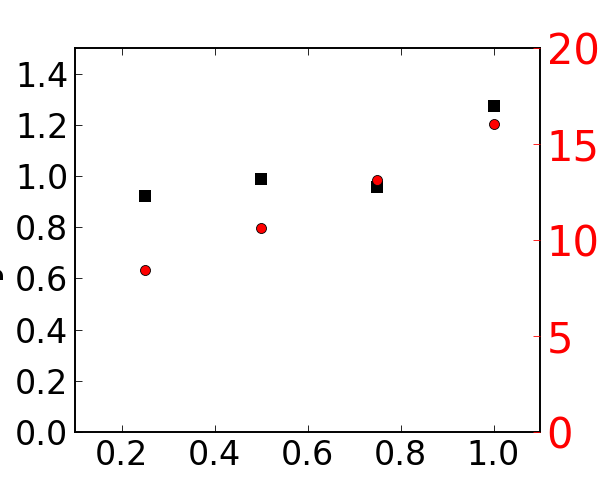

In [679]:
# Export I-H figure
lab = ['30mK']
Hs = np.linspace(0,2,num=9)

# calculate correlation length based on sigma
unit110 = 2*np.pi/(10.61/np.sqrt(2.))

sigma0 = fitpars0[0:4,3] - 0.02 # for PV fit: subtracting the estimated insRes (half width)
correL0 = 1/(unit110*sigma0)

sigma1 = fitpars1[0:4,4] - 0.02 # for PV fit: subtracting the estimated insRes (half width)
correL1 = 1/(unit110*sigma1)

sigma2 = fitpars2[0:4,0] # for convolute fit
correL2 = 1/(unit110*sigma2)
print(correL1, correL2)

fig, ax1 = plt.subplots(figsize=(5,4))
# Plot intensity
#ax1.scatter(Hs[0:5], np.insert(fitpars0[0:4,1],0,0)*1e3,c='k',label='30 mK',s=50, marker='s',linewidth=0,edgecolors=None) # set the first point to a different color
ax1.scatter(Hs[0:5], np.insert(fitpars1[0:4,2],0,0)*1e3,c='k',label='30 mK',s=50, marker='s',linewidth=0,edgecolors=None) # set the first point to a different color

ax1.set_ylim([0.0,1.5])
plt.xlabel('Field (T)', size=30)
plt.ylabel('Intensity($10^{-3}$ a.u.)', size=30)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

# Plot correlation length
ax2 = ax1.twinx()
#ax2.plot(Hs[1:5],correL0, 'bo')
#ax2.plot(Hs[1:5],correL1, 'bo')
ax2.plot(Hs[0:5],np.insert(correL2,0,0), 'o',c='r')

ax2.set_ylabel('Correlation Length ($\mathrm{\AA}$)',size=30, color='r')
ax2.tick_params('y', colors='r',labelsize=25)

plt.axis([0.1,1.1, 0,20])
#plt.legend(loc='upper left', frameon=False, scatterpoints=1,fontsize=18,handletextpad=0.3)
#plt.text(0.1,0.75,'Scattering sheet\nat zero', fontsize=20, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_sheet_int_corre.pdf'), bbox_inches='tight')
plt.show()

In [552]:
correL0 = 1/(unit110*0.4)
print correL0

2.985111285758405


## Cut along (00L)  <a id='30mk_cut00L'></a>

<IPython.core.display.Javascript object>


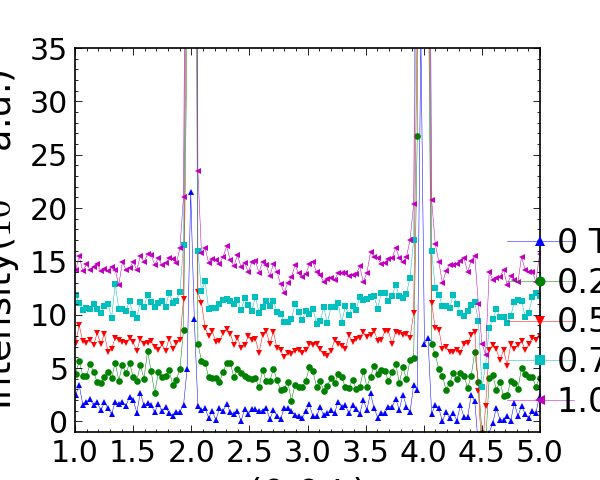

0
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


1
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
3
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
4
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


In [31]:
# Cut the 30mK data and plot spline
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # 10 points vertical
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110' # 10 points vertical

xlabel = ['(H -H 0)','(0 0 L)']
legs = ['0 T','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
markers = ['^','o','v', 's', '<', 'o', '8', 's', 'p']
colors =  ['g','bk','green','y','b','r','y','g','r','b']
xshift = [0,0,0.0002,0,-0.0002,0,0,0,0,0]
yshift = 3
intAx = 1 # 0: integrate ool, 1: integrate hho

intWidth = 0.2

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname_all[1:]):
#     if idx==5:
#         break
    print(idx)
    dat = loadE2_obj0(fpath,fn,info=0)
    dat = subE2_obj1(dat,bkg_20k)
    # Cut along [ool] integrating around zero(hho) and all vertical
    #mycut = cut2d(dat,[0,5],[-intWidth,intWidth],1)   
    mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[0,5], hho=[-intWidth,intWidth], intaxs=[0,2]) 
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift*idx, 1e3*0.00001*maskede, marker=markers[idx], 
                                  markersize=4,fmt='-o', mec='none',
                                  label=legs[idx], lw=0.3, capsize=0)
    
    # Cut along (hho) integrating around (oo1)/(003) and all vertical
    #mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[1.5,1.8], hho=[-5,5], intaxs=[0,1]) # (001)
#     mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[2.2,2.8], hho=[-5,5], intaxs=[0,1])# (003)
#     maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
#     maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
#     maskede = np.ma.masked_where(mycut.I==0, mycut.e)
#     line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift*idx, 1e3*0.00001*maskede, marker=markers[idx], markersize=4,fmt='o',
#                                   label=legs[idx], lw=0.3, capsize=0)
    
    # Cut along (hho) integrating 0-4(ool) excluding Bragg peaks and all vertical
    #mycut0 = cut2d(dat,[0.5,1.5],[-1.3,1.3],0)
    #mycut1 = cut2d(dat,[2.2,3.8],[-1.3,1.3],0)
    #maskedx = np.ma.masked_where(mycut0.I+mycut1.I==0, mycut0.x)
    #maskedy = np.ma.masked_where(mycut0.I+mycut1.I==0, (mycut0.I+mycut1.I)/2. )
    #line,caps,bars = plt.errorbar(maskedx,1e3*(maskedy+xshift[idx]), 1e3*0.0005*((mycut0.e**2+mycut1.e**2)/2)**0.5,
    #                              label=legs[idx], fmt='o',c=colors[idx], capsize=0)#  line, (errx_top, errx_bot, erry_top, erry_bot), (barsx, barsy) = errobj    
    
    # Cut along (hh0) integrating ool to get the 002 peak: too few data points! Use the 1500*1500*10 data
    #mycut = cut2d(dat,[1.8,2.2],[-1.3,1.3],0)
    #plt.errorbar(mycut.x, mycut.I, 0.001*mycut.e, label=legs[idx], fmt='-o', capthick=0)
    
    # Plot spline
    #from scipy import interpolate
    #spl = interpolate.UnivariateSpline(maskedx, 1e3*maskedy+yshift*idx, w=None, k=2, s=1)
    #plt.plot(maskedx, spl(maskedx),c=line.get_markerfacecolor())
    
plt.axis([1.,5,-1,35])
#plt.yscale("log", nonposx='clip'); 
plt.xlabel(xlabel[intAx],size=22)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=22)
plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18)
# get handles
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] for h in handles]
plt.gca().legend(handles, labels,loc=[0.9,0.],ncol=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()

#plt.text(0.08,0.08,'Integrated width\n [-{0:}, {0:}](H -H 0)'.format(intWidth), fontsize=14, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_cut_along(00l)_linear.pdf'), bbox_inches="tight",verbose=True)
plt.show()

In [25]:
plt.gca().legend(handles, labels,loc=[0.95,-0.05],ncol=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()
plt.tight_layout()
#plt.draw()
#plt.savefig(os.path.join(fpath,'30mk_cut_along(00l)_linear_2.pdf'), bbox_inches="tight",verbose=True)
plt.show()

## Cut along vertical (H-H0) <a id='30mk_cutH-H0'></a>

<IPython.core.display.Javascript object>


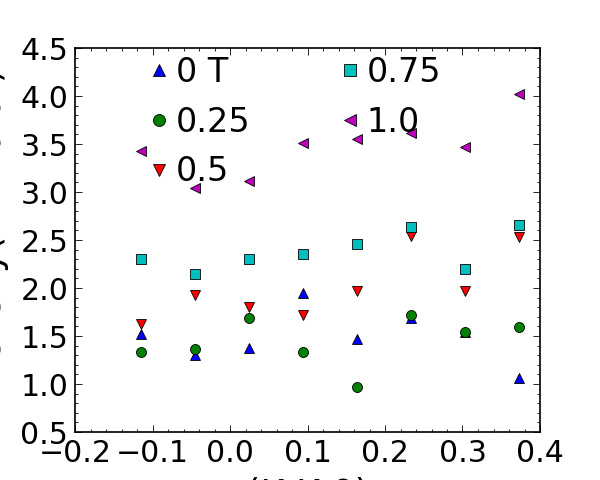

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice


30mK_0T_1and_half180-e210896_98_919.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


30mK_0p25T_one30-e210913.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
30mk_0p5T_one90-e210909.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
30mk_0p75T_one30-e210914.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
30mK_1T_two180-e210910-911-915.hdf


In [30]:
# Cut to get the vertical ax-I
xlabel = ['(K K 0)','(0 0 L)','(H -H 0)'] # (KK0) is vertical
#intAxs = (0,2) #h_ho is ax=0 (veritcal wavevector), ool is ax=1, hho is ax=2 
intAxs = (1,2) #h_ho is ax=0 (veritcal wavevector), ool is ax=1, hho is ax=2 
hhointWidth = 0.1

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname_all[1:]):
    if idx==5:
        break
    dat = loadE2_obj0(fpath,fn,info=0)
    dat = subE2_obj1(dat,bkg_20k)
    print(fn)
    # Cut along [ool] integrating around zero(hho)
    mycut0 = cut3d(dat, h_ho=[-1,1], ool=[1.0,1.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs)    
    #mycut1 = cut3d(dat, h_ho=[-1,1], ool=[2.2,3.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs) 
    mycut1 = cut3d(dat, h_ho=[-1,1], ool=[2.2,3.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs) 
    
    #  Cut along [ool] integrating around 0.3(hho)
    #mycut0 = cut3d(dat, h_ho=[-1,1], ool=[1,1.8], hho=[-hhointWidth+0.3,hhointWidth+0.3], intaxs=intAxs)    
    #mycut1 = cut3d(dat, h_ho=[-1,1], ool=[2.2,3.8], hho=[-hhointWidth+0.3,hhointWidth+0.3], intaxs=intAxs) 
    
    # Combine
    mycut = E2_data_1d(mycut0.x, (  mycut0.I   +mycut1.I)/2., (mycut0.e+mycut1.e)/2.)
    
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy, 1e3*0.00001*maskede,marker=markers[idx], label=legs[idx], fmt='o',lw=0.3, capthick=0)

#plt.yscale("log", nonposx='clip');
#plt.axis([-0.2,0.4,0,6])
xlab = list(set([0,1,2])-set(intAxs))[0]
plt.xlabel(xlabel[xlab],size=22)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=22)

plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

# remove the errorbar in the legend : http://swdg.io/2015/errorbar-legends/
from matplotlib import container
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
plt.gca().legend(handles, labels,loc=[0.08,0.6],scatterpoints=1,ncol=2,markerscale=1.2,
                 numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()

#plt.savefig(os.path.join(fpath,'30mk_cut_along(h_ho)_linear.pdf'), bbox_inches="tight",verbose=True)
plt.show()


## 30mK (002) peak <a id='30mk002'></a>

<IPython.core.display.Javascript object>


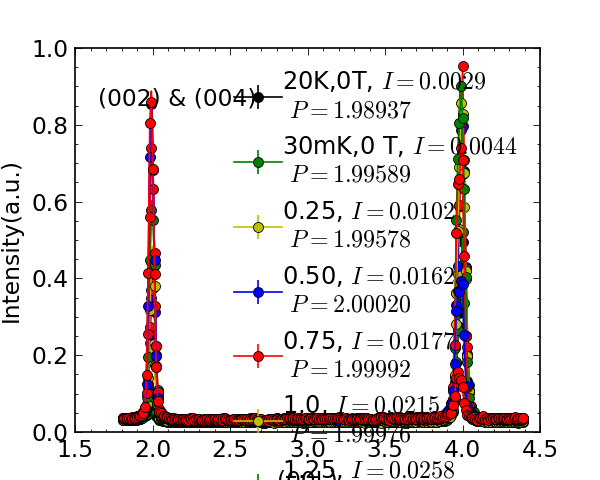

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


(0, array([ 18, 213]), array([1.99263, 4.0007 ]), array([0.06009, 0.49484]))
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf
(1, array([ 19, 213]), array([2.00292, 4.0007 ]), array([0.07864, 0.52015]))
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf
(2, array([ 18, 212]), array([1.99263, 3.9904 ]), array([0.232  , 0.70104]))
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
(3, array([ 19, 213]), array([2.00292, 4.0007 ]), array([0.37592, 0.79606]))
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
(4, array([ 19, 213]), array([2.00292, 4.0007 ]), array([0.4103 , 0.95351]))
2
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61

In [682]:
# Cut the 30mK data and fit the (002) peaks with shift data for bkg corr.   
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # less pixels
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51' # more pixels

xlabel = ['(00L)','(H-H2)']
## Cut along (00L) to see (002) and (004)
# for fname
whichF = fname
legs = ['0.25 T','0.50','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['green','y','b','r','y','g','r','b']
xshift = np.array([0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
# for fname_all
whichF = fname_all
legs = ['20K,0T','30mK,0 T','0.25','0.50','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['k','g','y','b','r','y','g','r','b','r']
xshift = np.array([0,0,0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0,0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
intAx = 0 # 0: integrate ool, 1: integrate hho
xplot = np.linspace(1.8,4.4,1000,endpoint=True)
text = '(002) & (004)'
## Cut along (HHL) to see (-1-13) and (113)
# for fname_90deg
# whichF = fname_90deg
# legs = ['20K,0T','30mK,0 T','0.50','1.0','2.0']
# colors = ['k','r','g','y','b']
# xshift = np.array([0,0,0.0002,0,-0.0002,0,0,0,0,0])*0 
# yshift = np.array([0,0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
# intAx = 1
# xplot = np.linspace(-1.5,1.5,1000,endpoint=True)
# text = '(-1-13) & (113)'

fitpars = []
plt.figure(figsize=(5,4))
for idx, fn in enumerate(whichF):
    #if idx==2:
    #    break
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)

    # Integrate ool to get the 002 peak   
    #mycut0 = cut2d0(sub,[1.8,2.2],[-0.5,0.5],0) # (002)
    #mycut0 = cut2d0(sub,[3.8,4.2],[-0.5,0.5],0) #（004）
    mycut0 = cut2d0(sub,[1.8,4.4],[-0.2,0.2],1) # （002）and (004）along (00L)
    #mycut0 = cut2d0(sub,[2.8,3.2],[-1.5,1.5],0) # （-1-13）and (113）along (HH0)
    nb_of_f = 1
    if nb_of_f==1: # only one cut
        x = mycut0.x + xshift[idx]
        y = mycut0.I + yshift[idx]
        e = mycut0.e
    if nb_of_f==2: # combined the two cut
        mycut1 = cut2d0(sub,[3.8,4.2],[-0.5,0.5],0)
        x = mycut0.x + xshift[idx]
        y = (np.nanmean(np.vstack([mycut0.I,mycut1.I]),axis=0) + yshift[idx] )
        e = np.nanmean(np.vstack([mycut0.e**2,mycut1.e**2]), axis=0)**0.5
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]
    
    # Find peak and fit   
    indexes = peakutils.indexes(y, thres=0.03, min_dist=160)
    print(idx, indexes, x[indexes], y[indexes])
    
    N = len(indexes)
    print N
    if N!=0:    
        params_0, lowBound, highBound = [0.0], [-0.1], [0.2] # constant bkg
        lb = [0,     -np.inf, 0.001,0] # amplitude, pos, width, frac;
        hb = [np.inf, np.inf, 0.2,  1] # for PV set hb_frac=1; for Gaussian set 0.001
        for j in xrange(N):
            params_0.extend([y[indexes[j]], x[indexes[j]], 0.05, 0.]) # for PV; for Gaussain set frac = 0
            lowBound.extend(lb)
            highBound.extend(hb) 
        #print(params_0)
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound, highBound]
        
        popt, pcov = curve_fit(lambda x, const, *params: wrapper_fit_func_PV_const(x, N, const, params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        #print(popt)
        fitpars.append(popt)
        plt.plot(xplot,wrapper_fit_func_PV_const(xplot,N,popt[0],popt[1:]),c=colors[idx])
        
    plt.errorbar(x,y,e, label=legs[idx]+', $I=%1.4f$ \n $P=%1.5f$'%tuple(popt[1:3]), fmt='-o',c=colors[idx], capthick=0)# set 5:7 for the 2nd peak   
    #plt.errorbar(x,y,e, label=legs[idx], fmt='-o', capthick=0)#, c=colors[idx])  
#plt.axis([-0.5,1.2,-1,5])
#plt.axis([-0.1,0.1,-0.1,0.6])
plt.xlabel(xlabel[intAx],size=14)
plt.ylabel('Intensity(a.u.)',size=14)
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

plt.text(0.05,0.85,text, fontsize=14, transform=plt.gca().transAxes)

leg = plt.legend(loc=1,numpoints=1,frameon=False,handletextpad=0).draggable()

# swap_and_right_align_legend
#vp = leg._legend_box._children[-1]._children[0]
#for c in vp._children:
    #c._children.reverse()
#vp.align="right"

plt.draw() 
plt.show()

[array([2.73922e-02, 2.93954e-03, 1.98937e+00, 3.19836e-02, 8.67029e-01, 2.60516e-02, 3.99678e+00, 2.63257e-02, 1.84492e-01]), array([0.02645, 0.00442, 1.99589, 0.02703, 0.97289, 0.02615, 3.99532, 0.02566, 0.26064]), array([0.03148, 0.0102 , 1.99578, 0.02148, 0.11957, 0.04004, 3.99508, 0.02728, 0.08626]), array([0.03121, 0.01621, 2.0002 , 0.02028, 0.14942, 0.04608, 3.99543, 0.02645, 0.156  ]), array([0.0312 , 0.01774, 1.99992, 0.01995, 0.22095, 0.05065, 3.99522, 0.02602, 0.21924]), array([0.02754, 0.02146, 1.99976, 0.02032, 0.25158, 0.04858, 3.99324, 0.02696, 0.04296]), array([3.34825e-02, 2.57533e-02, 1.99780e+00, 2.04353e-02, 1.18155e-01, 5.37251e-02, 3.98847e+00, 2.87429e-02, 1.30681e-18]), array([3.39189e-02, 3.05713e-02, 1.99602e+00, 1.94581e-02, 1.42265e-01, 4.39975e-02, 3.98565e+00, 2.82397e-02, 1.73901e-19]), array([0.03467, 0.03406, 1.99366, 0.01869, 0.12147, 0.02401, 3.98314, 0.02949, 0.01732]), array([0.03464, 0.03514, 1.99185, 0.01882, 0.08103, 0.00813, 3.97638, 0.02851, 0.

<IPython.core.display.Javascript object>


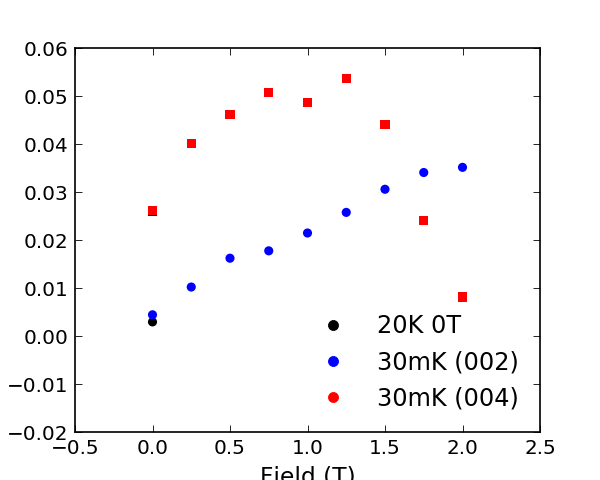

In [683]:
# Plot H-I
# (004) is out of the detector due to field-tilting
lab = ['30mK (002)','30mK (004)']
Hs = np.hstack([[0],np.linspace(0,2,num=9)])

#lab = ['30mK (-1-13)','30mK (113)']
#Hs = [0,0,0.5,1,2]
print fitpars
fitpars = np.array(fitpars)
plt.figure(figsize=(5,4))
plt.scatter(Hs,fitpars[:,1],c=['k']+['b']*(len(Hs)-1),label=lab[0],s=30, marker='o',linewidth=0,edgecolors=None) # set the first point to a different color
plt.scatter(Hs,fitpars[:,5],c=['k']+['r']*(len(Hs)-1),label=lab[1],s=30, marker='s',linewidth=0,edgecolors=None)
plt.xlabel('Field (T)',size=14)
plt.ylabel('Intensity(a.u.)',size=14)
#plt.xticks(color='k', size=14)
#plt.yticks(color='k', size=14) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

# creat legend
#import matplotlib.patches as mpatches
#handles = [mpatches.Patch(color=colour, label=label) for label, colour in [('a', a), ('b', b), ('c', c)]]
from matplotlib.lines import Line2D
handles = [Line2D(range(1),range(1), marker='o',linewidth=0, mec=colour, mfc=colour, label=label) for label, colour in [('20K 0T', 'k'), (lab[0], 'b'), (lab[1], 'r')]]
plt.legend(handles=handles, loc=0, frameon=False,numpoints=1)
#plt.legend(numpoints=1,frameon=False).draggable()

plt.show()

<IPython.core.display.Javascript object>


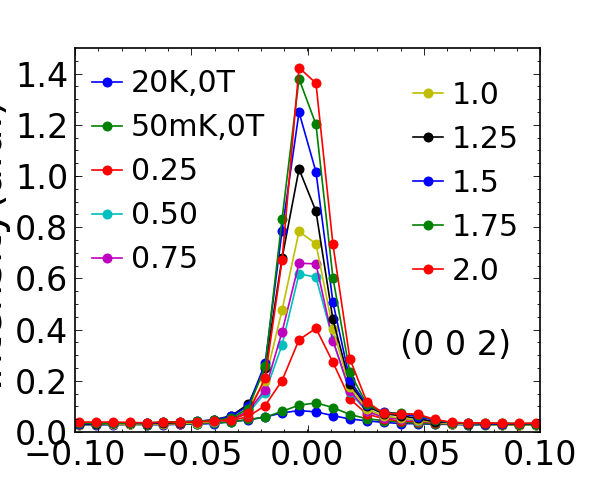

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_1p25T_one30-e210916.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_1p5T_one30-e210917.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_1p75T_e210918.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51\30mk_2T_one90-e210912.hdf


In [684]:
# Cut the 30mK data and fit the (002) peaks with shift data for bkg corr.   
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # less pixels
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix1500_1500_10_rot0p2_abc7p51_10p61_7p51' # more pixels

xlabel = ['(H -H 2)','(0 0 L)']
## Cut along (00L) to see (002) and (004)
# for fname_all
whichF = fname_all
legs = ['20K,0T','50mK,0T','0.25','0.50','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['k','g','y','b','r','y','g','r','b','r']
xshift = np.array([0,0,0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0,0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0

xplot = np.linspace(1.8,4.4,1000,endpoint=True)
text = '(0 0 2)'
intAx = 0 # 0: integrate ool, 1: integrate hho

fitpars = []
plt.figure(figsize=(5,4))
for idx, fn in enumerate(whichF):
    if idx==20:
        break
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)

    # Integrate ool to get the 002 peak   
    if intAx==1:
        mycut0 = cut2d0(sub,[1.8,4.4],[-0.2,0.2],1) # （002）and (004）along (00L)
    elif intAx==0:
        mycut0 = cut2d0(sub,[1.8,2.2],[-0.5,0.5],0) # （002）along (H-H0)
    
    x = mycut0.x + xshift[idx]
    y = mycut0.I + yshift[idx]
    e = mycut0.e

    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]
    
    # Find peak and fit   
    indexes = peakutils.indexes(y, thres=0.03, min_dist=160)   
    N = len(indexes)
    if N!=0:    
        params_0, lowBound, highBound = [0.0], [-0.1], [0.2] # constant bkg
        lb = [0,     -np.inf, 0.001,0] # amplitude, pos, width, frac;
        hb = [np.inf, np.inf, 0.2,  1] # for PV set hb_frac=1; for Gaussian set 0.001
        for j in xrange(N):
            params_0.extend([y[indexes[j]], x[indexes[j]], 0.05, 0.]) # for PV; for Gaussain set frac = 0
            lowBound.extend(lb)
            highBound.extend(hb) 
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound, highBound]
        
        popt, pcov = curve_fit(lambda x, const, *params: wrapper_fit_func_PV_const(x, N, const, params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        fitpars.append(popt)
        #plt.plot(xplot,wrapper_fit_func_PV_const(xplot,N,popt[0],popt[1:]),c=colors[idx])
        
    #plt.errorbar(x,y,e, label=legs[idx]+', $I=%1.4f$ \n $P=%1.5f$'%tuple(popt[1:3]), fmt='-o',c=colors[idx], capthick=0)# set 5:7 for the 2nd peak   
    plt.plot(x,y, label=legs[idx], marker='o',linestyle='-',mec='none') 

if intAx==1:
    plt.axis([1.9,2.1,0.02,1.0]) # along (00L)
elif intAx==0:
    plt.axis([-0.1,0.1,0.0,1.5]) # along (H-H0)
    
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity(a.u.)',size=25)
plt.minorticks_on()
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) 

plt.text(0.7,0.2,text, fontsize=20, transform=plt.gca().transAxes)

# Add two legends (mothed one)
# handles,labels = plt.gca().get_legend_handles_labels()
# leg = plt.legend(handles[0:5], labels[0:5], loc=1,numpoints=1,frameon=False)
# plt.legend(handles[5:], labels[5:], loc=3, frameon=False,numpoints=1) # it replaces the first one
# plt.gca().add_artist(leg); # add the first one

# Add two legends (method two)
handles,labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:5], labels[0:5], loc=[0.01,0.38],numpoints=1,frameon=False,fontsize=18,handlelength=1,handletextpad=0.3)
from matplotlib.legend import Legend
leg = Legend(plt.gca(), handles[5:], labels[5:], loc=[0.7,0.35], numpoints=1, frameon=False,fontsize=18,handlelength=1,handletextpad=0.3)
plt.gca().add_artist(leg);

#plt.savefig(os.path.join(fpath,'30mk_(002)_peak_hh0.pdf'), bbox_inches="tight",verbose=True)
plt.show()

In [685]:
#plt.tight_layout()
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, formatter = dict(float = lambda x: "%1.3f" % x )) 
print(np.array(fitpars))
#plt.savefig(os.path.join(fpath,'30mk_(002)_peak_00l.pdf'), bbox_inches="tight",verbose=True)

[[0.027 0.003 -0.002 0.018 0.669]
 [0.027 0.004 0.002 0.016 0.799]
 [0.028 0.012 0.002 0.012 0.533]
 [0.028 0.018 0.000 0.011 0.474]
 [0.028 0.019 -0.000 0.011 0.477]
 [0.026 0.022 -0.001 0.011 0.460]
 [0.029 0.028 -0.002 0.011 0.416]
 [0.030 0.032 -0.002 0.011 0.394]
 [0.031 0.035 -0.001 0.011 0.305]
 [0.032 0.036 0.000 0.010 0.336]]


[[2.748 0.275 -0.227 1.813 66.910]
 [2.737 0.395 0.203 1.584 79.853]
 [2.805 1.152 0.155 1.152 53.278]
 [2.782 1.769 0.009 1.108 47.440]
 [2.762 1.908 -0.026 1.104 47.741]
 [2.618 2.238 -0.075 1.121 45.989]
 [2.863 2.758 -0.188 1.098 41.647]
 [2.952 3.193 -0.189 1.057 39.395]
 [3.121 3.485 -0.127 1.058 30.519]
 [3.186 3.630 0.015 1.014 33.635]]


<IPython.core.display.Javascript object>


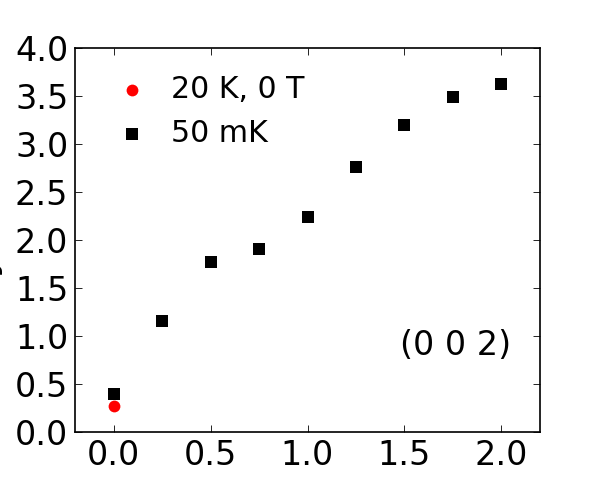

In [686]:
# Export I-H figure for (002)
lab = ['50mK','50mK (004)']
Hs = np.hstack([[0],np.linspace(0,2,num=9)])

fitpars1 = np.array(fitpars)*100
print fitpars1
plt.figure(figsize=(5,4))
plt.scatter(Hs[0],fitpars1[0,1], c='r',label='20 K, 0 T', s=50, marker='o',linewidth=0,edgecolors=None) # set the first point to a different color
plt.scatter(Hs[1:],fitpars1[1:,1],c='k',label='50 mK',s=50, marker='s',linewidth=0,edgecolors=None) # set the first point to a different color
plt.axis([-0.2,2.2,0,4])
plt.xlabel('Field (T)',size=25)
plt.ylabel('Intensity($10^{-2}$ a.u.)',size=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

plt.legend(loc='best', frameon=False, scatterpoints=1,fontsize=18,handletextpad=0.3)
plt.text(0.7,0.2,'(0 0 2)', fontsize=20, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_(002)_peak_int_hh0.pdf'), bbox_inches='tight')
plt.show()

## Cut3d line and slice <a id='30mk_slice'></a>

### Plot the vertical plane to get the misaligment

<IPython.core.display.Javascript object>


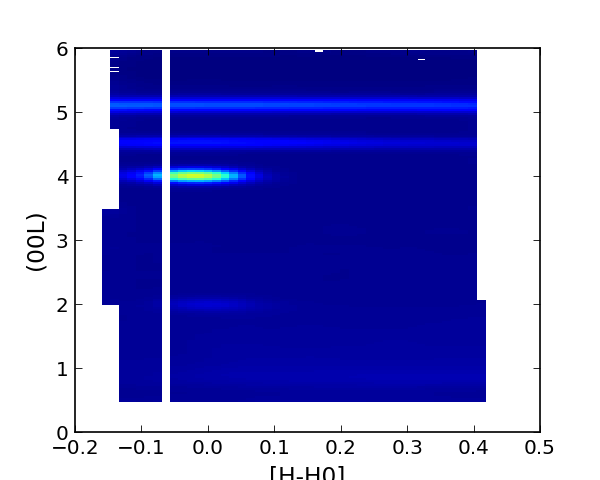

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


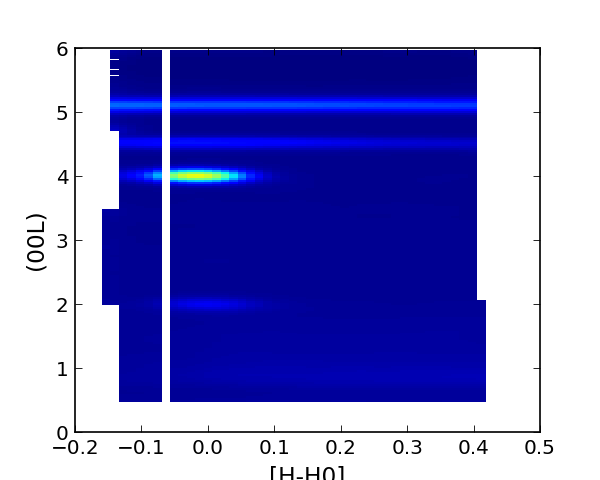

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf


<IPython.core.display.Javascript object>


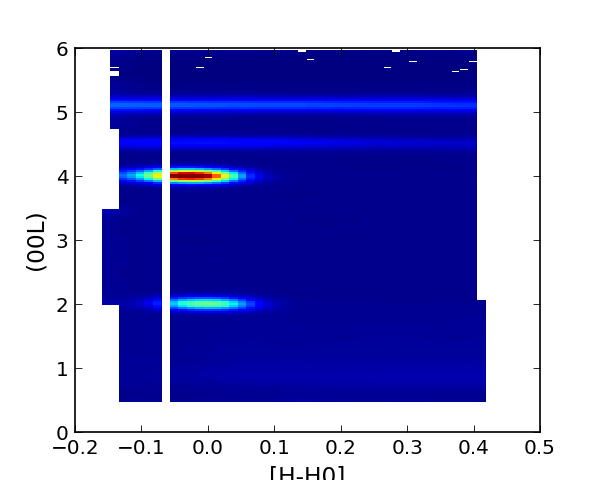

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf


<IPython.core.display.Javascript object>


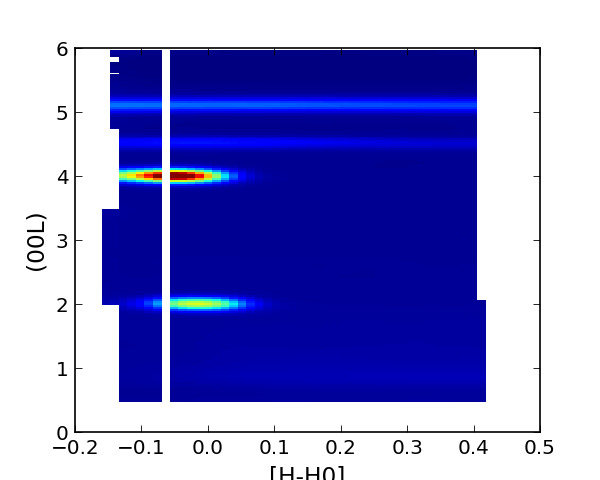

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf


<IPython.core.display.Javascript object>


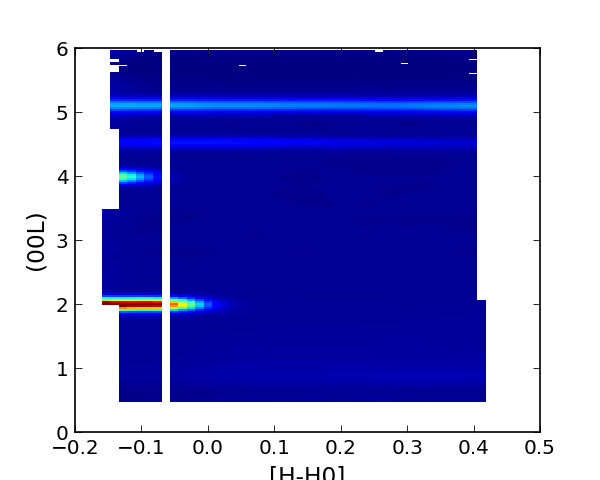

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_2T_one90-e210912.hdf


In [687]:
# Cut the 30mK data: slice   
#fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51' # 10 points vertical
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51' # 50 points vertical

axlabel = ['[H-H0]','(00L)','(HH0)']
# for fname
whichF = fname
legs = ['0.25 T','0.50','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['green','y','b','r','y','g','r','b']
xshift = np.array([0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
# for fname_all
whichF = fname_all
legs = ['20K,0T','30mK,0 T','0.25','0.50','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['k','g','y','b','r','y','g','r','b','r']
xshift = np.array([0,0,0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0,0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
intAx = 0 # 0: integrate ool, 1: integrate hho
xplot = np.linspace(1.8,4.4,1000,endpoint=True)
text = '(002) & (004)'
## Cut along (HHL) to see (-1-13) and (113)
# for fname_90deg
whichF = fname_90deg
legs = ['20K,0T','30mK,0 T','0.50','1.0','2.0']
colors = ['k','r','g','y','b']
xshift = np.array([0,0,0.0002,0,-0.0002,0,0,0,0,0])*0 
yshift = np.array([0,0,0.0003,0, 0.0002,0,0.0005,0,0,0])*0
xplot = np.linspace(-1.5,1.5,1000,endpoint=True)
text = '(-1-13) & (113)'

for idx, fn in enumerate(whichF):
    fig, axs = plt.subplots(1,1,figsize=(5,4))
    #if idx==1:
    #    break
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)

    #intAx=[1];mycut0 = cut3d(sub,[-0.5,0.5],[2.8,3.2],[-1.5,1.5],[1]) # vertical slice with（-1-13）and (113） #h_ho, ool, hho, intaxs
    #intAx=[1]; mycut0 = cut3d(sub,[-0.5,0.5],[3.8,4.2],[-2.5,2.5],intAx) # vertical slice with（-2-24）and (224） #h_ho, ool, hho, intaxs
    intAx=[2];mycut0 = cut3d(sub,[-0.5,0.5],[0,6],[-0.2,0.2],[2]) # vertical slice with (002) and (004) #h_ho, ool, hho, intaxs
    #intAx=[0];mycut0 = cut3d(sub,[-0.5,0.5],[-6,6],[-6,6],[0]) # horizontal slice # h_ho, ool, hho, intaxs

    x = mycut0.x
    y = mycut0.y
    Z = mycut0.I
    
    sigma = (2,2)
    Z = myGfilter(Z, sigma, mode='constant')
    Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
    pcol = axs.pcolormesh(x, y, Zm.T, cmap='jet', linewidth=0, rasterized=True,vmax=1)
    axIdx = list(set([0,1,2])-set(intAx))
    plt.xlabel(axlabel[axIdx[0]],size=14)
    plt.ylabel(axlabel[axIdx[1]],size=14)

plt.show()

<IPython.core.display.Javascript object>


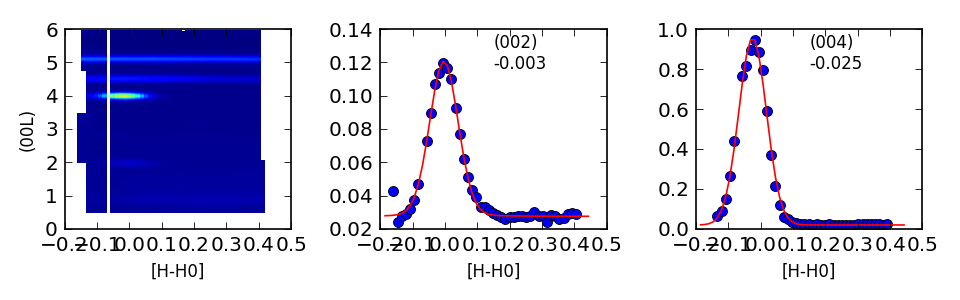

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


[0.027 0.011 -0.003 0.052 0.080]
[0.020 0.100 -0.025 0.050 0.000]
0.866636354773742


<IPython.core.display.Javascript object>


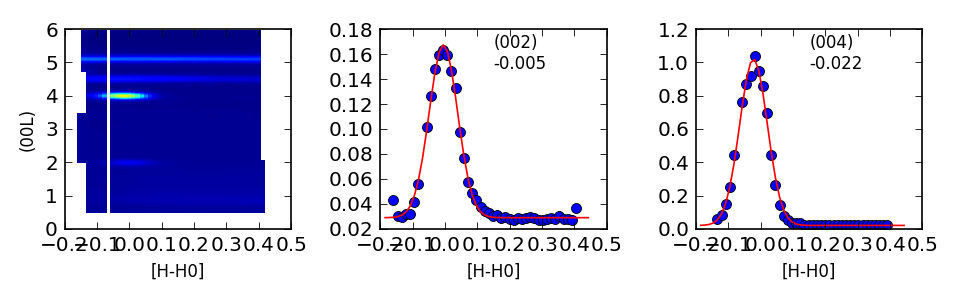

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf
[0.029 0.015 -0.005 0.052 0.000]
[0.021 0.107 -0.022 0.050 0.000]
0.6928153589726607


<IPython.core.display.Javascript object>


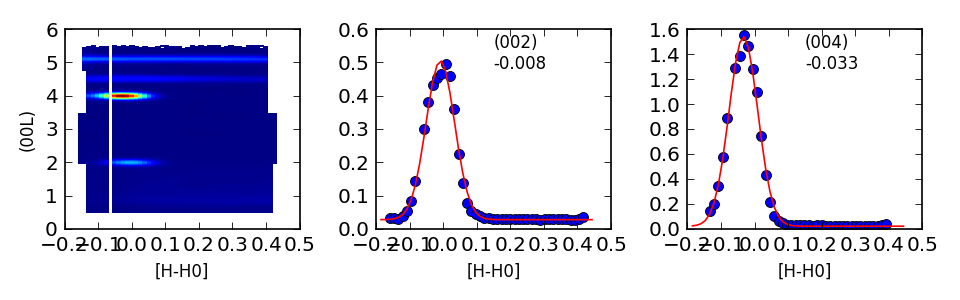

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_0p25T_one30-e210913.hdf
[0.028 0.051 -0.008 0.050 0.000]
[0.022 0.163 -0.033 0.050 0.000]
1.002413578399255


<IPython.core.display.Javascript object>


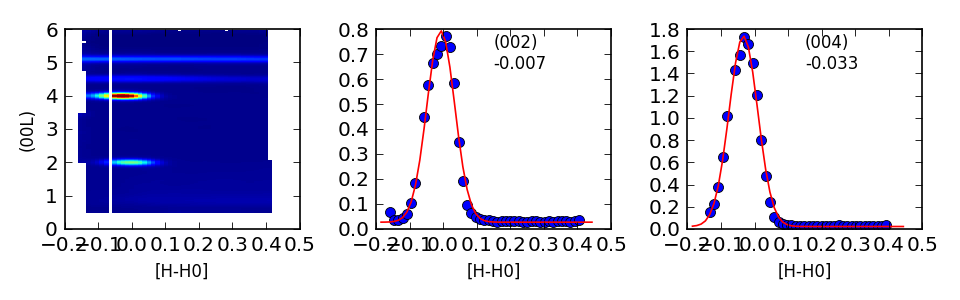

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
[0.027 0.080 -0.007 0.049 0.000]
[0.022 0.183 -0.033 0.050 0.000]
1.059315133249448


<IPython.core.display.Javascript object>


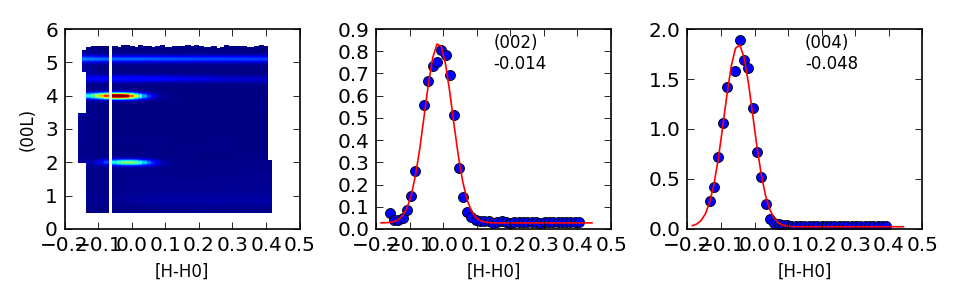

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_0p75T_one30-e210914.hdf
[0.027 0.085 -0.014 0.049 0.000]
[0.022 0.196 -0.048 0.050 0.000]
1.376591171138502


<IPython.core.display.Javascript object>


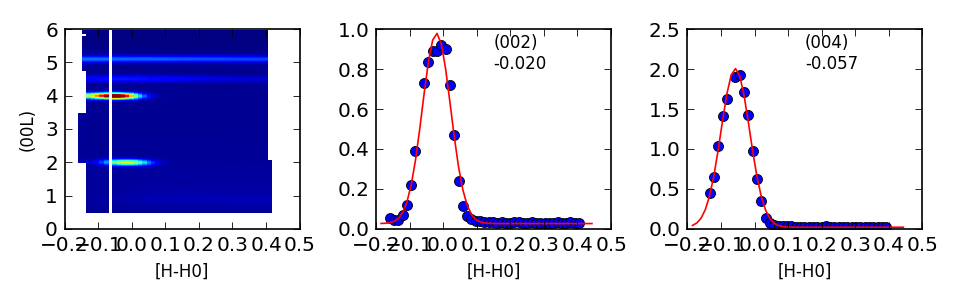

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
[0.027 0.101 -0.020 0.050 0.000]
[0.021 0.212 -0.057 0.050 0.000]
1.5143773861668948


<IPython.core.display.Javascript object>


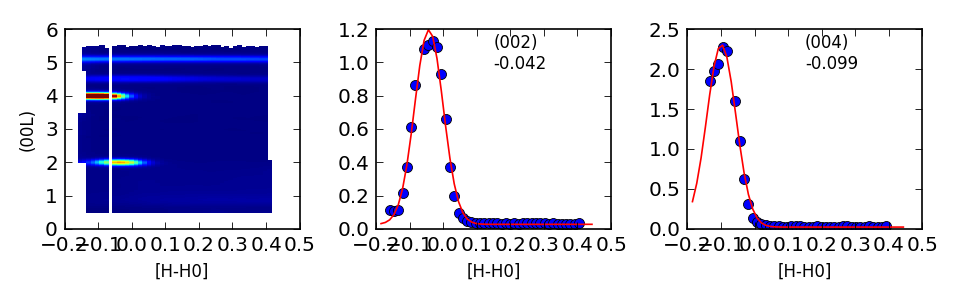

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_1p25T_one30-e210916.hdf
[0.028 0.125 -0.042 0.050 0.000]
[0.023 0.248 -0.099 0.051 0.000]
2.281851703173314


<IPython.core.display.Javascript object>


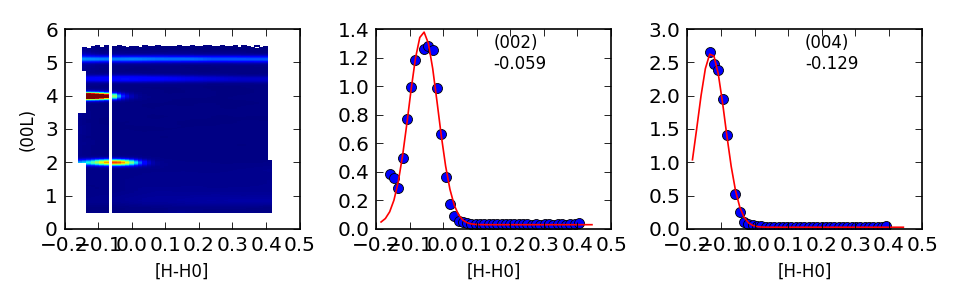

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_1p5T_one30-e210917.hdf
[0.029 0.146 -0.059 0.051 0.000]
[0.025 0.268 -0.129 0.048 0.000]
2.8178488023688844


<IPython.core.display.Javascript object>


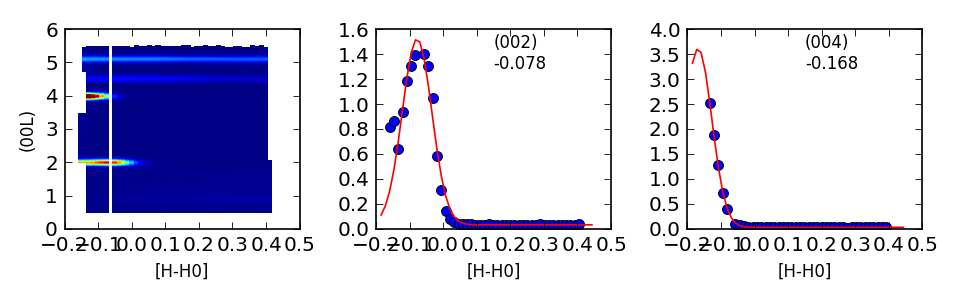

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_1p75T_e210918.hdf
[0.032 0.165 -0.078 0.052 0.000]
[0.032 0.366 -0.168 0.048 0.000]
3.6531996758177216


<IPython.core.display.Javascript object>


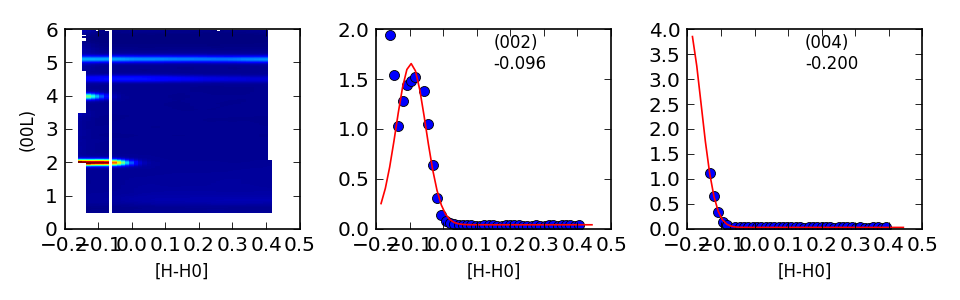

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_2T_one90-e210912.hdf
[0.041 0.179 -0.096 0.052 0.000]
[0.030 0.419 -0.200 0.048 0.000]
4.214122938536144


In [712]:
# Slice (HH0)-(H-H0) and cut through (002) and (004)
# To estimate the misalignment 
# Use the file with 50pixels vertical for accuracy
def pvoigt_const(x,constant=0,amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5):
    return constant + pvoigt(x, amplitude, center, sigma, fraction)

whichF = fname_all
params_0 = [0,     0.12,    0, 0.050, 0.5] #pvoigt(x, amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5)
bounds = [[-np.inf,   0, -0.2, 0.048,   0],
          [ np.inf,np.inf,0.5, 0.052,   1]]
for idx, fn in enumerate(whichF):
    if idx==15:
        break
    fig, axs = plt.subplots(1,3,figsize=(8,2.5))
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)
    
    # Plot 2D map
    intAx=[2];mycut0 = cut3d(sub,[-0.5,0.5],[0,6],[-0.2,0.2],intAx) # vertical slice with (002) and (004) #h_ho, ool, hho, intaxs
    x = mycut0.x
    y = mycut0.y
    Z = mycut0.I
    sigma = (2,2)
    Z = myGfilter(Z, sigma, mode='constant')
    Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
    pcol = axs[0].pcolormesh(x, y, Zm.T, cmap='jet', linewidth=0, rasterized=True,vmax=1)
    axIdx = list(set([0,1,2])-set(intAx))
    axs[0].set_xlabel(axlabel[axIdx[0]],size=10)
    axs[0].set_ylabel(axlabel[axIdx[1]],size=10)
    
    # Plot 1D cup
    intAx = [1,2]
    axIdx = list(set([0,1,2])-set(intAx))
    # cut through（002）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[1.9,2.1],[-0.1,0.1],intAx) 
    axs[1].plot(mycut0.x,mycut0.I,'o'); 
    axs[1].set_xlabel(axlabel[axIdx[0]],size=10)
    try:
        mask = ~np.isnan(mycut0.I)
        mask[0:3] = False # not fit the first 3 points
        popt, pcov = curve_fit(pvoigt_const, mycut0.x[mask], mycut0.I[mask], p0=params_0, bounds=bounds)
        print(popt)
        p002 = popt[2]
        axs[1].plot(mycut0.x, pvoigt_const(mycut0.x,*popt),c='r')
        axs[1].text(0.5,0.8,'(002)\n%1.3f'%popt[2],fontsize=10, transform=axs[1].transAxes)
    except:
        print('fail to fit')
        
    # cut through（004）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-0.1,0.1],intAx) 
    axs[2].plot(mycut0.x,mycut0.I,'o'); 
    axs[2].set_xlabel(axlabel[axIdx[0]],size=10)
    try:
        mask = ~np.isnan(mycut0.I)
        popt, pcov = curve_fit(pvoigt_const, mycut0.x[mask], mycut0.I[mask], p0=params_0, bounds=bounds)
        print(popt)
        p004 = popt[2]
        axs[2].plot(mycut0.x, pvoigt_const(mycut0.x,*popt),c='r')
        axs[2].text(0.5,0.8,'(004)\n%1.3f'%popt[2],fontsize=10, transform=axs[2].transAxes)
    except:
        print('fail to fit')
        
    print np.arctan((p002-p004)/2*2.**0.5 )*180/np.pi
    
    plt.tight_layout() # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
    plt.show()

In [74]:
print 'Misalignment of the (00L) axis'
print np.arctan( (-0.003+0.023)/2*2.**0.5 )*180/np.pi, 'degree in zero field'
print np.arctan( (-0.012+0.031)/2*2.**0.5 )*180/np.pi, 'degree in 0.5 T field'
print np.arctan( (-0.022+0.057)/2*2.**0.5 )*180/np.pi, 'degree in 1.0 T field'
print np.arctan( (-0.056+0.135)/2*2.**0.5 )*180/np.pi, 'degree in 1.75 T field'
print np.arctan( (-0.073+0.13)/2*2.**0.5 )*180/np.pi, 'degree in 1.75 T field'
print np.arctan( (-0.087+(0.008-0.0057)+0.132)/2*2.**0.5 )*180/np.pi, 'degree in 2.0 T field (estimate (004) peak position based the peak width)'

Misalignment of the (00L) axis
0.8102306720437779 degree in zero field
0.7697241408074481 degree in 0.5 T field
1.41770879632968 degree in 1.0 T field
3.197301540386395 degree in 1.75 T field
2.3080620762885666 degree in 1.75 T field
1.9156091963439938 degree in 2.0 T field (estimate (004) peak position based the peak width)


<IPython.core.display.Javascript object>


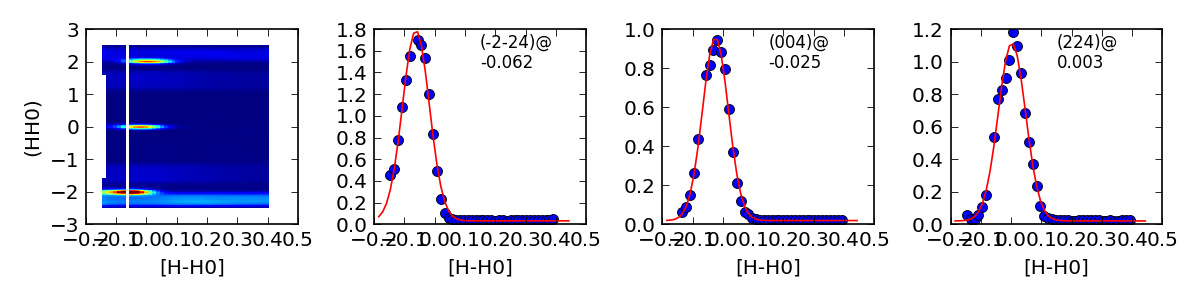

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\20k_0T_two180 -e210922_23_24.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


[0.033 0.196 -0.062 0.052 0.000]
[0.020 0.100 -0.025 0.050 0.000]
[0.021 0.124 0.003 0.053 0.000]
0.7826892359629163


<IPython.core.display.Javascript object>


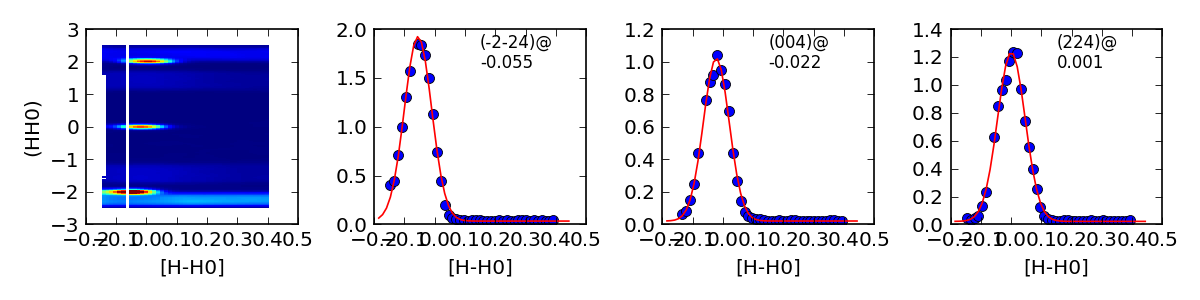

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_0T_1and_half180-e210896_98_919.hdf
[0.034 0.214 -0.055 0.053 0.000]
[0.021 0.107 -0.022 0.050 0.000]
[0.022 0.139 0.001 0.054 0.000]
0.6503249056666663


<IPython.core.display.Javascript object>


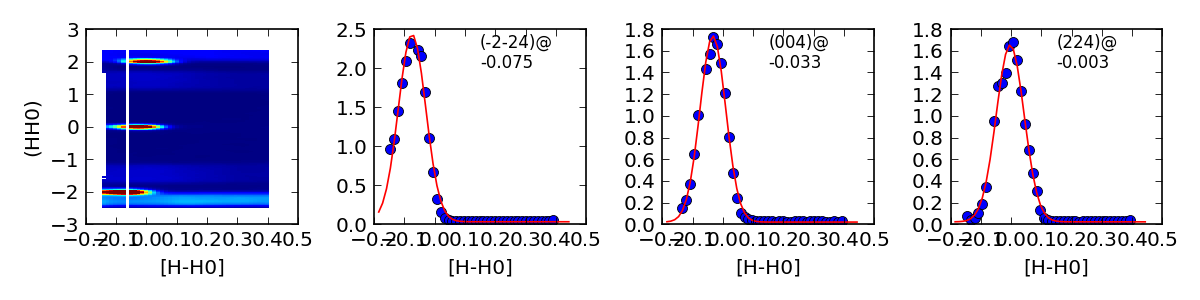

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_0p5T_one90-e210909.hdf
[0.034 0.272 -0.075 0.053 0.000]
[0.022 0.183 -0.033 0.050 0.000]
[0.024 0.188 -0.003 0.054 0.000]
0.8613891528490195


<IPython.core.display.Javascript object>


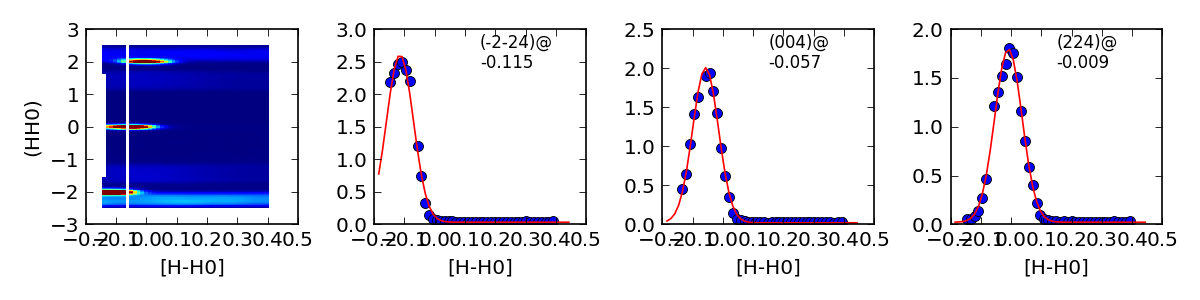

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mK_1T_two180-e210910-911-915.hdf
[0.033 0.287 -0.115 0.052 0.000]
[0.021 0.212 -0.057 0.050 0.000]
[0.022 0.201 -0.009 0.053 0.000]
1.3805593867498318


<IPython.core.display.Javascript object>

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_50_rot0p2_abc7p51_10p61_7p51\30mk_2T_one90-e210912.hdf
fail to fit
[0.029 0.094 -0.152 0.029 0.147]
[0.029 0.300 -0.046 0.054 0.000]
3.049926415015883


In [713]:
# Slice (HH0)-(H-H0) and cut through (-2-24), (004) and (224)
# To estimate the misalignment
# (HH0) is tilted ~1.1 and ~3 deg. in zero field and 2T (estimate the center of peak 004 and 224) field

params_0 = [0,     0.12,    0, 0.050, 0.5] #pvoigt(x, amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5)
bounds = [[-np.inf,   0, -0.2, 0.000,   0],
          [ np.inf,np.inf,0.5, 0.080,   1]]

whichF = fname_90deg
for idx, fn in enumerate(whichF):
#     if idx==1:
#         break
    fig, axs = plt.subplots(1,4,figsize=(10,2.5))
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)
    
    # Plot 2D map
    intAx=[1]; mycut0 = cut3d(sub,[-0.5,0.5],[3.8,4.2],[-2.5,2.5],intAx) # vertical slice with（-2-24）and (224） #h_ho, ool, hho, intaxs
    x = mycut0.x
    y = mycut0.y
    Z = mycut0.I
    sigma = (2,2)
    Z = myGfilter(Z, sigma, mode='constant')
    Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
    pcol = axs[0].pcolormesh(x, y, Zm.T, cmap='jet', linewidth=0, rasterized=True,vmax=1)
    axIdx = list(set([0,1,2])-set(intAx))
    axs[0].set_xlabel(axlabel[axIdx[0]],size=12)
    axs[0].set_ylabel(axlabel[axIdx[1]],size=12)
    
    # Plot 1D cup
    intAx = [1,2]
    axIdx = list(set([0,1,2])-set(intAx))
    # cut through（-2-24）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-2.1,-1.9],intAx) 
    axs[1].plot(mycut0.x,mycut0.I,'o'); 
    axs[1].set_xlabel(axlabel[axIdx[0]],size=12)
    #axs[1].text(0.5,0.8,'(-2-24)',fontsize=10, transform=axs[1].transAxes)
    try:
        mask = ~np.isnan(mycut0.I)
        #mask[0:3] = False # not fit the first 3 points
        popt, pcov = curve_fit(pvoigt_const, mycut0.x[mask], mycut0.I[mask], p0=params_0, bounds=bounds)
        print(popt)
        p_224 = popt[2]
        axs[1].plot(mycut0.x, pvoigt_const(mycut0.x,*popt),c='r')
        axs[1].text(0.5,0.8,'(-2-24)@\n%1.3f'%popt[2],fontsize=10, transform=axs[1].transAxes)
    except:
        print('fail to fit')
        
    # cut through（004）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-0.1, 0.1],intAx) 
    axs[2].plot(mycut0.x,mycut0.I,'o'); 
    axs[2].set_xlabel(axlabel[axIdx[0]],size=12)
    #axs[2].text(0.5,0.8,'(004)',fontsize=10, transform=axs[2].transAxes)
    try:
        mask = ~np.isnan(mycut0.I)
        popt, pcov = curve_fit(pvoigt_const, mycut0.x[mask], mycut0.I[mask], p0=params_0, bounds=bounds)
        print(popt)
        p004 = popt[2]
        axs[2].plot(mycut0.x, pvoigt_const(mycut0.x,*popt),c='r')
        axs[2].text(0.5,0.8,'(004)@\n%1.3f'%popt[2],fontsize=10, transform=axs[2].transAxes)
    except:
        print('fail to fit')
        
    # cut through（224）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[ 1.9, 2.1],intAx) 
    axs[3].plot(mycut0.x,mycut0.I,'o');
    axs[3].set_xlabel(axlabel[axIdx[0]],size=12)
    #axs[3].text(0.5,0.8,'(224)',fontsize=10, transform=axs[3].transAxes)
    try:
        mask = ~np.isnan(mycut0.I)
        popt, pcov = curve_fit(pvoigt_const, mycut0.x[mask], mycut0.I[mask], p0=params_0, bounds=bounds)
        print(popt)
        p224 = popt[2]
        axs[3].plot(mycut0.x, pvoigt_const(mycut0.x,*popt),c='r')
        axs[3].text(0.5,0.8,'(224)@\n%1.3f'%popt[2],fontsize=10, transform=axs[3].transAxes)
    except:
        print('fail to fit')
    print np.arctan((p224-p004)/2)*180/np.pi
    plt.tight_layout() # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.show()

In [82]:
print 'Misalignment of the (HH0) axis'
print np.arctan((0.053+0.006)/4)*180/np.pi, 'degree in zero field'
print np.arctan((0.055+0.009)/4)*180/np.pi, 'degree in 0.5 T field'
print np.arctan((0.11-0.011)/4)*180/np.pi, np.arctan((0.055-0.011)/2)*180/np.pi, 'degree in 1.0 T field'
print np.arctan((0.134+(0.055-0.006)-0.055)/2)*180/np.pi, 'degree in 2.0 T field (estimate (004) peak position based the peak width)'

Misalignment of the (HH0) axis
0.8450514675364077 degree in zero field
0.9166542563852879 degree in 0.5 T field
1.417781097044578 1.2603038465035896 degree in 1.0 T field
3.661935575519803 degree in 2.0 T field (estimate (004) peak position based the peak width)


# 450mK 0.5T and 1T data <a id='450mk'></a>

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mK_0T_two180-e210899-904.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mk_0p5T_one90-e210908.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mK_2T-e210905-907.hdf


<IPython.core.display.Javascript object>


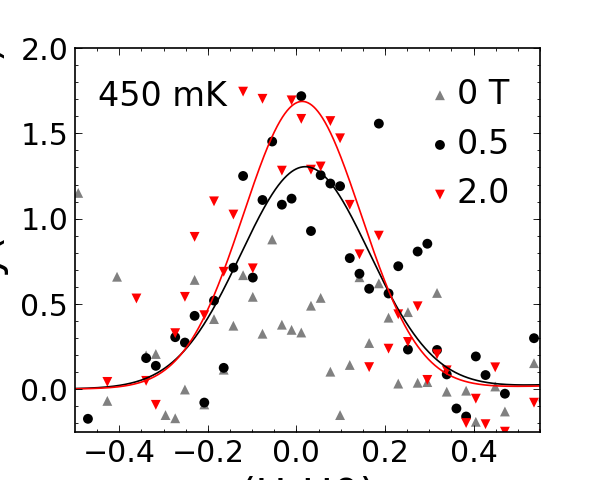

[ 0.19798 -0.00781  0.17756  0.26097  0.56066  1.00106  0.01376  1.     ]
[4.74124e-01 2.00000e-02 1.71418e-01 9.86457e-10 5.23049e+00 1.01098e+00 1.56783e-02 2.02363e-01]
[5.60288e-01 1.29456e-02 1.56399e-01 7.80558e-18 7.32431e+00 1.03871e+00 1.54979e-02 1.25919e-01]


In [623]:
# 450mK 0.5T and 1T data
fname450 = [r'450mK_0T_two180-e210899-904.hdf',
            r'450mk_0p5T_one90-e210908.hdf',
            r'450mK_2T-e210905-907.hdf']

# Cut and fit the stick and (110) peaks
data0 = loadE2_obj0(fpath,fname450[0],info=0)
data0 = subE2_obj0(data0,bkg_20k)
data1 = loadE2_obj0(fpath,fname450[1],info=0)
data1 = subE2_obj0(data1,bkg_20k)
data2 = loadE2_obj0(fpath,fname450[2],info=0)
data2 = subE2_obj0(data2,bkg_20k)
          
xlabel = ['(H-H0)','(00L)']
legs   = ['0 T','0.5','2.0']
colors = ['grey','black','r']
xshift = np.array([0.0, 0, 0.03])
yshift = np.array([-0.0005, 0.0003, -0.0006])
intAx = 0 # 0: integrate ool, 1: integrate hho

xplot = np.linspace(-0.5,1.2,2000,endpoint=True)
pknb = [2,2,2]

nb_of_f = 3

plt.figure(figsize=(5,4))
for idx, fn in enumerate([data0,data1,data2]):     
    # Integrate 0-4(ool) excluding Bragg peaks        
    #mycut0 = cut2d0(sub,[1.8,2.2],[-0.5,0.5],0)
    #mycut1 = cut2d0(sub,[3.8,4.2],[-0.5,0.5],0)
    if nb_of_f==1: # only one cut
        mycut0 = cut2d0(fn,[1,1.8],[-0.5,1.3],0)
        x = mycut0.x + xshift[idx]
        y = mycut0.I + yshift[idx]
        e = mycut0.e
    if nb_of_f==2: # only one cut
        mycut1 = cut2d0(fn,[2.2,3.8],[-0.5,1.3],0)  
        x = mycut1.x + xshift[idx]
        y = mycut1.I + yshift[idx]
        e = mycut1.e
    if nb_of_f==3: # combined the two cut
        #mycut0 = cut2d0(fn,[0.5,1.5],[-0.5,1.3],0)
        #mycut1 = cut2d0(fn,[2.2,3.8],[-0.5,1.3],0)
        mycut0 = cut2d0(fn,[1.0,1.5],[-0.5,1.3],0)
        mycut1 = cut2d0(fn,[2.2,3.8],[-0.5,1.3],0)
        x = mycut0.x + xshift[idx]
        y = (np.nanmean(np.vstack([mycut0.I,mycut1.I]),axis=0) + yshift[idx] )
        e = np.nanmean(np.vstack([mycut0.e**2,mycut1.e**2]), axis=0)**0.5
        
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],1e3*(y[mask]+yshift[idx]),e[mask]

    plt.scatter(mycut0.x, y, label=legs[idx], marker=markers[idx],c=colors[idx],edgecolors='none',s=35)
   
    # Find peak and fit: diffuse and (110)   
    params_0 = [0.8,     0., 0.2, 0.5,  50,  1.0, 0.1, 0.5]
    bounds = [ [0,    -0.02, 0.1, 0,      0, 0.9, 0.0, 0],
               [np.inf,0.02, 0.3, 1, np.inf, 1.2, 0.4, 1]] # amplitude, pos, withd, frac
    try:
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, pknb[idx], params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=err, absolute_sigma=False)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))
        print(popt)
    except:
        print('Failed')
     
    #line,caps,bars = plt.errorbar(mycut0.x,1e3*(masked+shift[idx]), 1e3*0.0002*((mycut0.e**2+mycut1.e**2)/2)**0.5,
    #                              label=legs[idx], fmt='o',c=colors[idx],mec='none', capthick=0)
    if idx!=0:
        plt.plot(xplot,wrapper_fit_func_PV(xplot,pknb[idx],popt),c=colors[idx])
    
plt.axis([-0.5,0.55,-0.25,2.0])
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)
plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.text(0.05,0.85,'450 mK', fontsize=20, transform=plt.gca().transAxes)
plt.legend(loc='best',scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()    

#plt.savefig(os.path.join(fpath,'450mk_cut.pdf'), bbox_inches="tight",verbose=True)
plt.show()

### Only layers of [0.2,0.4]

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mk_0p5T_one90-e210908.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


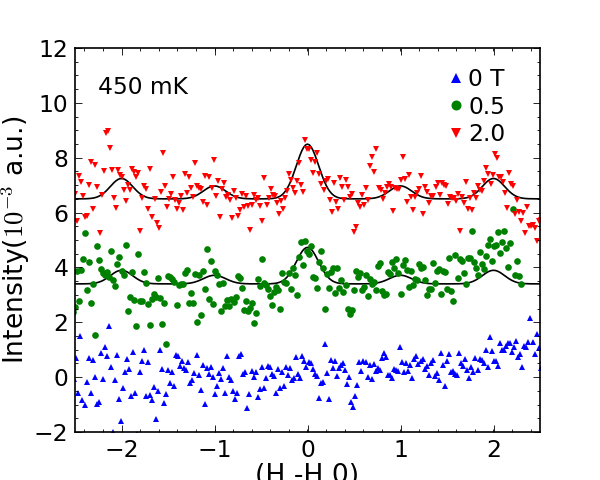

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mK_0T_two180-e210899-904.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mk_0p5T_one90-e210908.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix500_500_10_rot0p2_abc7p51_10p61_7p51\450mK_2T-e210905-907.hdf
[]


In [644]:
# Cut the 30mK data and plot spline
xlabel  = ['(H -H 0)','(0 0 L)']
legs    = ['0 T','0.5','2.0']
markers = ['^','o','v']
colors  = ['g','bk','green']
xshift  = [0,-0.04,0.03]
yshift  = np.array([-0.0007, 0.0007, -0.001])
yshift0 = 3
# amplitude and shfit of simulation for h_ho=[0.2,0.5]
yshift_simu = [0,0.4,0.5]
simu_amp    = [0,11,20]
simu_amp    = [0,20,30]
intAx = 0 # 0: integrate ool, 1: integrate hho

# Mask for the powder rings
data = loadE2_obj0(fpath, fname450[1]) # Do not change!!! (450mK 0.5T)
z1, y1, x1 = np.meshgrid(data.z, data.y, data.x, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 + 2*z1**2)
mask = (rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.6)

xfit = np.linspace(-0.5,0.5,100)
fitpars_pv_const = []
fitpars_pv_const_k = []

mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0,sigma_g=0.02)
pars['sigma_g'].set(value=0.02,vary = False)
fitpars_lm = []

dofit = [True,True,True]
dofit = [False,False,False]

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname450):
#     if idx==11:
#         break
    # first plot simulation
    if idx!=0 and True:
        simu_sm = np.vstack([simu[:,0],gaussian_filter1d(simu[:,1],sigma=6)/np.max(simu[:,1])]).T
        plt.plot(simu_sm[:,0], simu_amp[idx]*simu_sm[:,1]+yshift0*idx+yshift_simu[idx], c='black')
        
    dat = loadE2_obj0(fpath, fn, info=0)
    dat = subE2_obj1(dat, bkg_20k)
    dat.I[mask] = np.nan
    
    # Cut along [hh0] integrating (ool) and all vertical (h-ho)
    #mycut0 = cut3d(dat, h_ho=[0.1,0.5], ool=[0,1.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut1 = cut3d(dat, h_ho=[0.1,0.5], ool=[2.2,3.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut  = cut3d(dat, h_ho=[0.1,0.5], ool=[4.2,4.8], hho=[-5,5], intaxs=[0,1]) 
    #mycut.I = np.nanmean(np.vstack([mycut0.I, mycut1.I, mycut.I]), axis=0)
    
    mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[1.5,5], hho=[-5,5], intaxs=[0,1]) 
    #mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[0,3], hho=[-5,5], intaxs=[0,1]) # to show the streak at [110]
    #mycut = cut3d(dat, h_ho=[0.2,0.5], ool=[3,5], hho=[-5,5], intaxs=[0,1]) # to show the streak at [224]
    
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)+xshift[idx]
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)+yshift[idx]
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift0*idx, 1e3*0.00001*maskede,
                                  marker=markers[idx],markersize=4,fmt='o',mec='none',
                                  label=legs[idx], lw=0.3, capsize=0)
    # Fit the peak
    x, y = maskedx[200:255], maskedy[200:255]
    
    if idx!=0 and dofit[0]: # fit with PV founction + const
        params_0 = [      0, 0.001,       0,  0.05, 0.5] # const, amplitude, pos, width, frac;
        lb       = [-np.inf,     0, -np.inf, 0.001,   0] 
        hb       = [ np.inf, np.inf, np.inf, 0.200,   1] # for PV set hb_frac=1; for Gaussian set 0.001
        bounds   = [lb, hb]
        popt, pcov = curve_fit(lambda x, const, *params: wrapper_fit_func_PV_const(x, 1, const, params), 
                               x, y, p0=params_0, bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        fitpars_pv_const.append(popt)
        plt.plot(x,wrapper_fit_func_PV_const(x,1,popt[0],popt[1:])*1e3+yshift0*idx,c=line.get_color())
        
    if idx!=0 and dofit[1]: # fit with PV founction + const + k*x (upper lim for const for 0.75T background)
        params_0 = [      0,  0.000,   0.001,       0, 0.050, 0.5] # const, k, amplitude, pos, width, frac;
        lb       = [-np.inf, -0.005,       0, -np.inf, 0.001,   0] 
        hb       = [ np.inf,  0.005,  np.inf,  np.inf, 0.200,   1] # for PV set hb_frac=1; for Gaussian set 0.001
        bounds   = [lb, hb]
        popt, pcov = curve_fit(lambda x, const, k, *params: wrapper_fit_func_PV_const_k(x, 1, const, k, params), 
                               x, y, p0=params_0, bounds=bounds)#, sigma=e, absolute_sigma=True)# if initio value is outside bounds, error
        fitpars_pv_const_k.append(popt)
        plt.plot(xfit,wrapper_fit_func_PV_const_k(xfit,1,popt[0],popt[1],popt[2:])*1e3+yshift0*idx,c=line.get_color())
    if idx!=0 and dofit[2]:# Fit with limfit (convolute)
        result =  mod.fit(y, params=pars, x=x)
        sigma = result.best_values['sigma']
        unit110 = 2*np.pi/(10.61/np.sqrt(2.))
        correL = 1/(unit110*sigma)
        print(result.best_values,'\n',correL)
        fitpars_lm.append(result.best_values.values())
        plt.plot(x,result.best_fit*1e3+yshift0*idx, c=line.get_color())

plt.axis([-2.5,2.5,-2,12])
#plt.axis([-0.4,0.4,-1,3])
plt.xlabel(xlabel[intAx],size=16, labelpad=1)
plt.ylabel('Intensity($10^{-3}$ a.u.)', size=16, labelpad=1)
plt.minorticks_on()
plt.tick_params(labelsize=14)
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)
# Remove the error bar in the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] for h in handles]
plt.gca().legend(handles, labels,loc=[0.75,0.72],ncol=1,scatterpoints=1,numpoints=1,frameon=False,
                 fontsize=14,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()
plt.text(0.05,0.88,'450 mK', fontsize=14, transform=plt.gca().transAxes)
plt.savefig(os.path.join(fpath,'450mk_cut_along(hho)_no0layer.pdf'), bbox_inches="tight",verbose=True)
plt.show()
print fitpars_pv_const_k

# Orientation corrected data: subtraction and plot, fit  <a id='corrected'></a>

In [653]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/'  
fname = [r'30mk_2T_one90-e210912_corrected3angles.hdf',
         r'20k_0T_two180 -e210922_23_24_corrected3angles.hdf'
        ]
fnameBkg = '20k_0T_two180 -e210922_23_24_corrected3angles.hdf'

bkg = loadE2_obj0(fpath,fnameBkg,info=0)

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/20k_0T_two180 -e210922_23_24_corrected3angles.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice


D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/30mk_2T_one90-e210912_corrected3angles.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


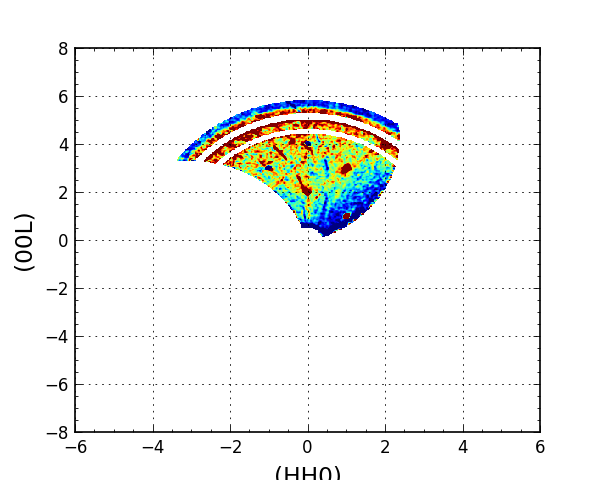

In [652]:
# Plot data
data = loadE2_obj0(fpath,fname[0],info=0)
sub = subE2_obj1(data,bkg) # the new subtraction func

Z = myGfilter(sub.I2d, sigma=[1,1], mode='constant')

# # Mask the data of powder ring
x1, y1= np.meshgrid(sub.x,sub.y, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 )
Z[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.8)] = np.nan # for 30mK
Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color

#plot2D(sub.x, sub.y, Zm, vmin=0.001,vmax= 0.01)
plot2D(sub.x, sub.y, Zm, vmin=0,vmax= 0.008, xlim =None, ylim=None);

<IPython.core.display.Javascript object>


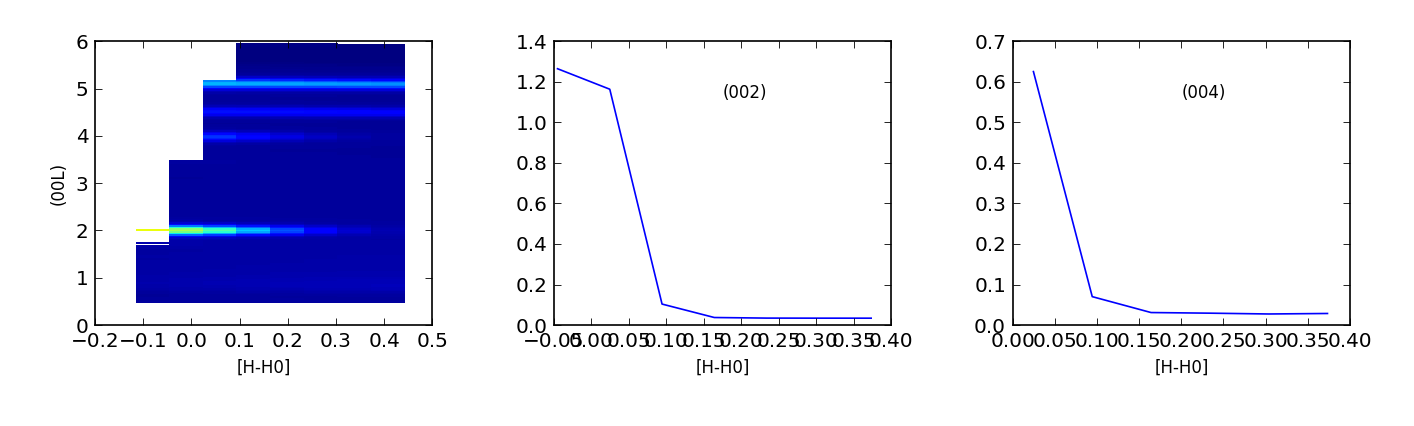

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/30mk_2T_one90-e210912_corrected3angles.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


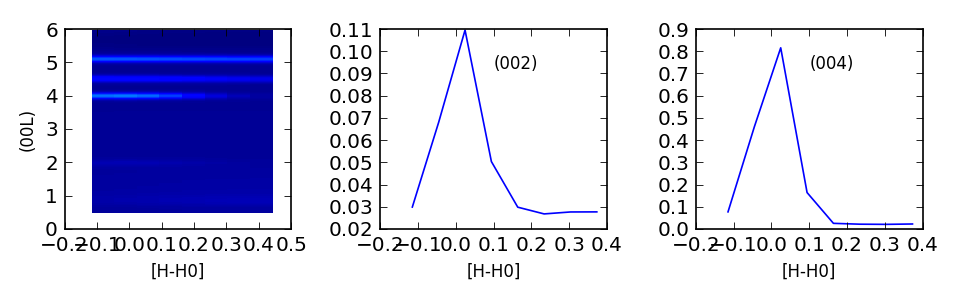

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/20k_0T_two180 -e210922_23_24_corrected3angles.hdf


In [654]:
# Slice (HH0)-(H-H0) and cut through (002) and (004)
# To estimate the misalignment 
# Use the file with 50pixels vertical for accuracy

whichF = fname
for idx, fn in enumerate(whichF):
#     if idx==1:
#         break
    fig, axs = plt.subplots(1,3,figsize=(8,2.5))
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)
    
    # Plot 2D map
    intAx=[2];mycut0 = cut3d(sub,[-0.5,0.5],[0,6],[-0.2,0.2],intAx) # vertical slice with (002) and (004) #h_ho, ool, hho, intaxs
    x = mycut0.x
    y = mycut0.y
    Z = mycut0.I
    sigma = (2,2)
    Z = myGfilter(Z, sigma, mode='constant')
    Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
    pcol = axs[0].pcolormesh(x, y, Zm.T, cmap='jet', linewidth=0, rasterized=True,vmax=1)
    axIdx = list(set([0,1,2])-set(intAx))
    axs[0].set_xlabel(axlabel[axIdx[0]],size=10)
    axs[0].set_ylabel(axlabel[axIdx[1]],size=10)
    
    # Plot 1D cup
    intAx = [1,2]
    axIdx = list(set([0,1,2])-set(intAx))
    # cut through（002）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[1.9,2.1],[-0.1,0.1],intAx) 
    axs[1].plot(mycut0.x,mycut0.I); 
    axs[1].set_xlabel(axlabel[axIdx[0]],size=10)
    axs[1].text(0.5,0.8,'(002)',fontsize=10, transform=axs[1].transAxes)
    # cut through（004）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-0.1,0.1],intAx) 
    axs[2].plot(mycut0.x,mycut0.I); 
    axs[2].set_xlabel(axlabel[axIdx[0]],size=10)
    axs[2].text(0.5,0.8,'(004)',fontsize=10, transform=axs[2].transAxes)
    plt.tight_layout() # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
    plt.show()

<IPython.core.display.Javascript object>


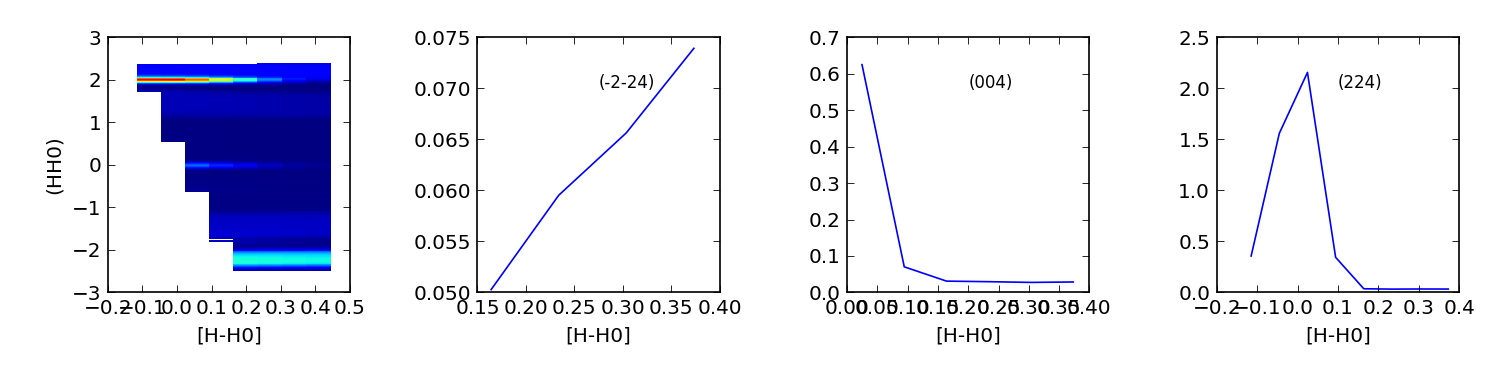

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/30mk_2T_one90-e210912_corrected3angles.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


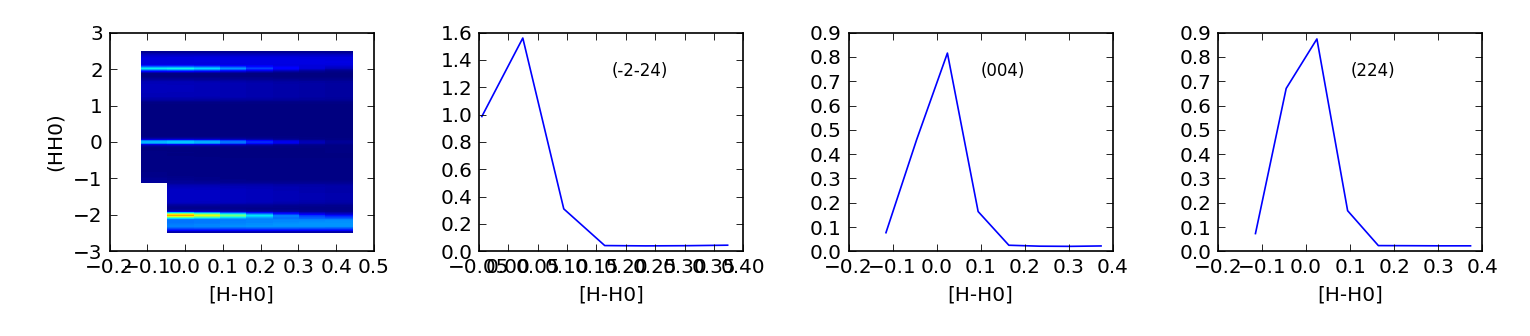

D:\5_Neutron Scattering\6_E2_April_2015\field_along110\pix_500_500_10_rot3angles_abc7p51_10p61_7p51/20k_0T_two180 -e210922_23_24_corrected3angles.hdf


In [655]:
# Slice (HH0)-(H-H0) and cut through (-2-24), (004) and (224)
# To estimate the misalignment
# (HH0) is tilted ~1.1 and ~3 deg. in zero field and 2T (estimate the center of peak 004 and 224) field
whichF = fname
for idx, fn in enumerate(whichF):
#     if idx==1:
#         break
    fig, axs = plt.subplots(1,4,figsize=(10,2.5))
    sub = loadE2_obj0(fpath,whichF[idx],info=0)
    #sub = subE2_obj0(data,bkg)
    
    # Plot 2D map
    intAx=[1]; mycut0 = cut3d(sub,[-0.5,0.5],[3.8,4.2],[-2.5,2.5],intAx) # vertical slice with（-2-24）and (224） #h_ho, ool, hho, intaxs
    x = mycut0.x
    y = mycut0.y
    Z = mycut0.I
    sigma = (2,2)
    Z = myGfilter(Z, sigma, mode='constant')
    Zm = np.ma.masked_where(np.isnan(Z),Z) # mask Nan values then plot in white color
    pcol = axs[0].pcolormesh(x, y, Zm.T, cmap='jet', linewidth=0, rasterized=True,vmax=1)
    axIdx = list(set([0,1,2])-set(intAx))
    axs[0].set_xlabel(axlabel[axIdx[0]],size=12)
    axs[0].set_ylabel(axlabel[axIdx[1]],size=12)
    
    # Plot 1D cup
    intAx = [1,2]
    axIdx = list(set([0,1,2])-set(intAx))
    # cut through（-2-24）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-2.1,-1.9],intAx) 
    axs[1].plot(mycut0.x,mycut0.I); 
    axs[1].set_xlabel(axlabel[axIdx[0]],size=12)
    axs[1].text(0.5,0.8,'(-2-24)',fontsize=10, transform=axs[1].transAxes)
    # cut through（004）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[-0.1, 0.1],intAx) 
    axs[2].plot(mycut0.x,mycut0.I); 
    axs[2].set_xlabel(axlabel[axIdx[0]],size=12)
    axs[2].text(0.5,0.8,'(004)',fontsize=10, transform=axs[2].transAxes)
    # cut through（224）along vertical 
    mycut0 = cut3d(sub,[-0.5,0.5],[3.9,4.1],[ 1.9, 2.1],intAx) 
    axs[3].plot(mycut0.x,mycut0.I);
    axs[3].set_xlabel(axlabel[axIdx[0]],size=12)
    axs[3].text(0.5,0.8,'(224)',fontsize=10, transform=axs[3].transAxes)
    plt.tight_layout() # https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.show()